# 🧱 DCGAN - Bricks Data

In this notebook, we'll walk through the steps required to train your own DCGAN on the bricks dataset

In [1]:
# Run these lines in Colab
!git clone https://github.com/mxagar/generative_ai_book.git
!mkdir notebooks
!mkdir chekpoint
!mkdir data
!mkdir output
!mkdir models
!mv generative_ai_book/notebooks/utils.py ./notebooks/utils.py
!mv generative_ai_book/notebooks/03_vae/03_vae_faces/vae_utils.py ./notebooks/vae_utils.py
!pip install python-dotenv

Cloning into 'generative_ai_book'...
remote: Enumerating objects: 737, done.
remote: Counting objects: 100% (279/279), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 737 (delta 184), reused 153 (delta 137), pack-reused 458 (from 1)
Receiving objects: 100% (737/737), 43.50 MiB | 10.94 MiB/s, done.
Resolving deltas: 100% (419/419), done.


In [10]:
from dotenv import load_dotenv
import os

# Load environment variables from the .env file
load_dotenv()

# Set an environment variable
# Get values from ./scripts/download.sh
# E.g., celebrity faces dataset: jessicali9530 celeba-dataset
os.environ['KAGGLE_DATASET_USER'] = 'joosthazelzet'
os.environ['KAGGLE_DATASET'] = 'lego-brick-images'

In [6]:
import os
os.system("cd data/ && kaggle datasets download -d $KAGGLE_DATASET_USER/$KAGGLE_DATASET")
!unzip -q -o data/$KAGGLE_DATASET.zip -d data/$KAGGLE_DATASET
!rm data/$KAGGLE_DATASET.zip

In [11]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)

from notebooks.utils import display, sample_batch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0. Parameters <a name="parameters"></a>

In [12]:
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
EPOCHS = 300
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

## 1. Prepare the data <a name="prepare"></a>

In [13]:
train_data = utils.image_dataset_from_directory(
    "./data/lego-brick-images/dataset/",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 40000 files.


In [14]:
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(lambda x: preprocess(x))

In [15]:
train_sample = sample_batch(train)

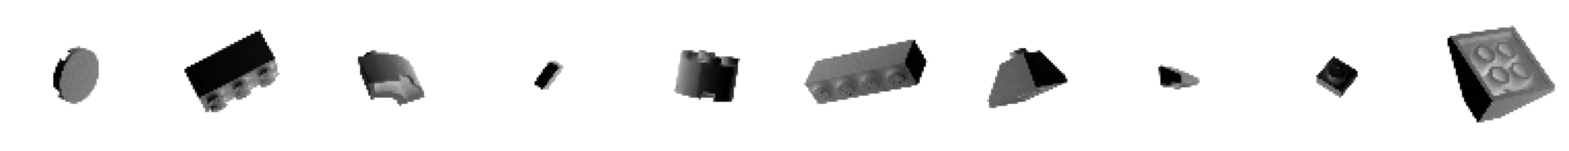

In [16]:
display(train_sample)

## 2. Build the GAN <a name="build"></a>

In [17]:
discriminator_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(
    discriminator_input
)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    512, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    1,
    kernel_size=4,
    strides=1,
    padding="valid",
    use_bias=False,
    activation="sigmoid",
)(x)
discriminator_output = layers.Flatten()(x)

discriminator = models.Model(discriminator_input, discriminator_output)
discriminator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 512)           │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 4, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 1, 1, 1)             │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,765,312 (10.55 MB)

 Trainable params: 2,763,520 (10.54 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [18]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS,
    kernel_size=4,
    strides=2,
    padding="same",
    use_bias=False,
    activation="tanh",
)(x)
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1, 1, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 4, 4, 512)           │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 4, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 8, 8, 256)           │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 16, 16, 128)         │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 32, 32, 64)          │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 64, 64, 1)           │           1,024 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,576,576 (13.64 MB)

 Trainable params: 3,574,656 (13.64 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [19]:
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Train the discriminator on fake images
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training=True
            )
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(
                generated_images, training=True
            )

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(real_labels, fake_predictions)

        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}

In [20]:
# Create a DCGAN
dcgan = DCGAN(
    discriminator=discriminator, generator=generator, latent_dim=Z_DIM
)

In [25]:
if LOAD_MODEL:
    dcgan.load_weights("./checkpoint/checkpoint.weights.h5")

## 3. Train the GAN <a name="train"></a>

In [26]:
dcgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [27]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.weights.h5",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )

Epoch 1/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - d_acc: 0.8162 - d_fake_acc: 0.8117 - d_loss: 0.3598 - d_real_acc: 0.8207 - g_acc: 0.1883 - g_loss: 3.6480
Saved to ./output/generated_img_000.png


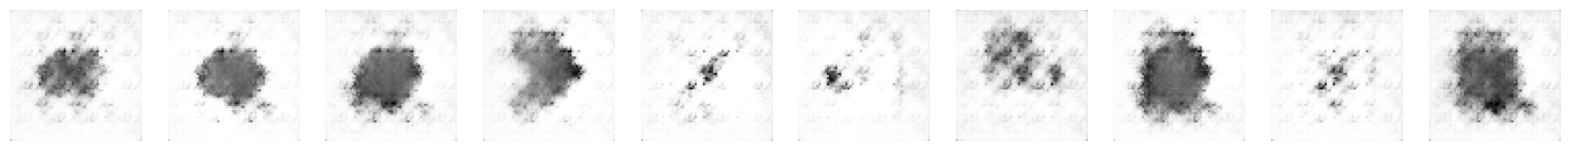

313/313 ━━━━━━━━━━━━━━━━━━━━ 117s 292ms/step - d_acc: 0.8162 - d_fake_acc: 0.8117 - d_loss: 0.3597 - d_real_acc: 0.8207 - g_acc: 0.1883 - g_loss: 3.6475
Epoch 2/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - d_acc: 0.8837 - d_fake_acc: 0.8883 - d_loss: 0.1223 - d_real_acc: 0.8792 - g_acc: 0.1117 - g_loss: 4.2304
Saved to ./output/generated_img_001.png


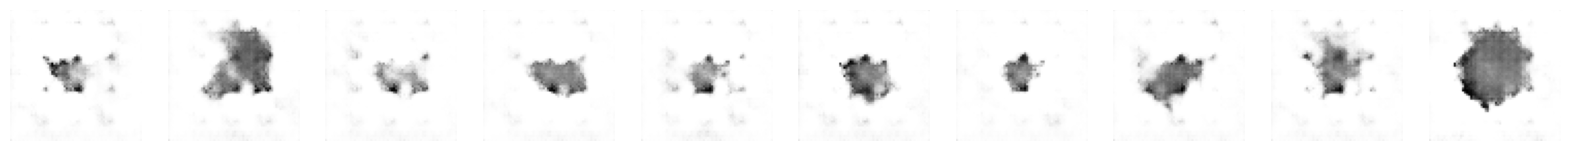

313/313 ━━━━━━━━━━━━━━━━━━━━ 106s 240ms/step - d_acc: 0.8837 - d_fake_acc: 0.8883 - d_loss: 0.1222 - d_real_acc: 0.8792 - g_acc: 0.1117 - g_loss: 4.2306
Epoch 3/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - d_acc: 0.8748 - d_fake_acc: 0.8780 - d_loss: 0.1343 - d_real_acc: 0.8716 - g_acc: 0.1220 - g_loss: 4.4465
Saved to ./output/generated_img_002.png


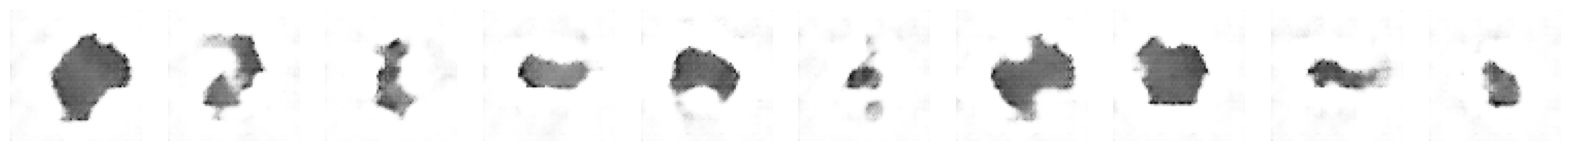

313/313 ━━━━━━━━━━━━━━━━━━━━ 74s 235ms/step - d_acc: 0.8748 - d_fake_acc: 0.8780 - d_loss: 0.1344 - d_real_acc: 0.8716 - g_acc: 0.1220 - g_loss: 4.4460
Epoch 4/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - d_acc: 0.8640 - d_fake_acc: 0.8665 - d_loss: 0.1796 - d_real_acc: 0.8614 - g_acc: 0.1335 - g_loss: 4.0543
Saved to ./output/generated_img_003.png


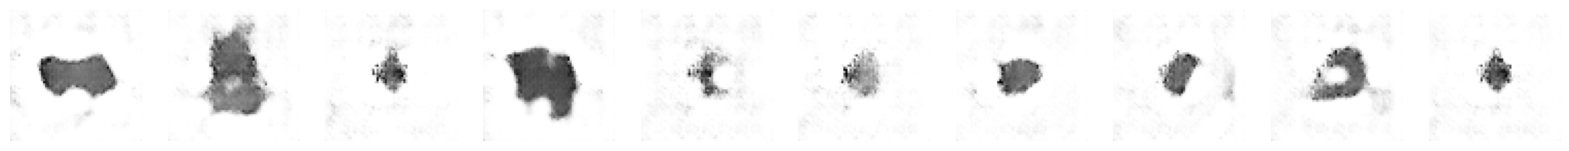

313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 238ms/step - d_acc: 0.8640 - d_fake_acc: 0.8666 - d_loss: 0.1794 - d_real_acc: 0.8614 - g_acc: 0.1334 - g_loss: 4.0551
Epoch 5/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - d_acc: 0.8749 - d_fake_acc: 0.8748 - d_loss: 0.1590 - d_real_acc: 0.8750 - g_acc: 0.1252 - g_loss: 3.8090
Saved to ./output/generated_img_004.png


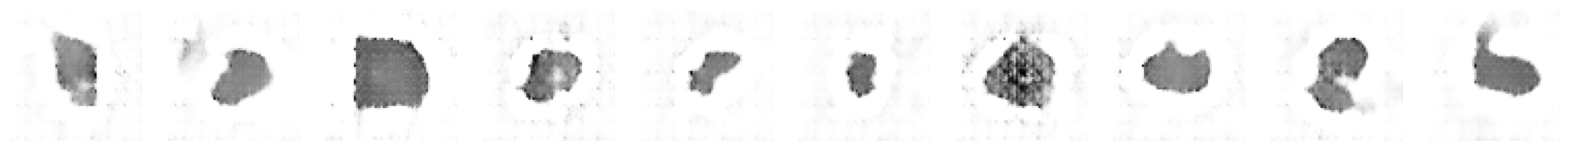

313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 242ms/step - d_acc: 0.8748 - d_fake_acc: 0.8747 - d_loss: 0.1591 - d_real_acc: 0.8750 - g_acc: 0.1253 - g_loss: 3.8091
Epoch 6/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - d_acc: 0.8895 - d_fake_acc: 0.8888 - d_loss: 0.1204 - d_real_acc: 0.8902 - g_acc: 0.1112 - g_loss: 3.8142
Saved to ./output/generated_img_005.png


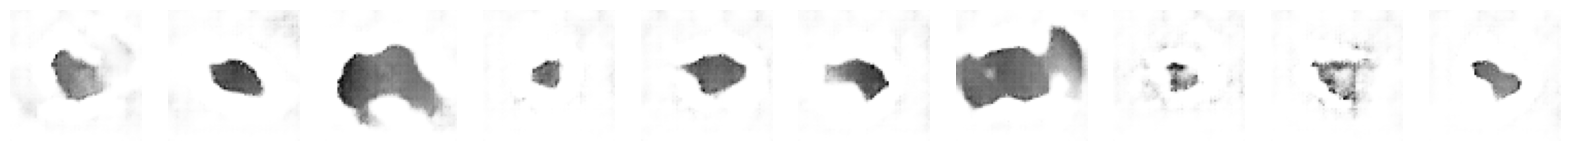

313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 243ms/step - d_acc: 0.8895 - d_fake_acc: 0.8888 - d_loss: 0.1204 - d_real_acc: 0.8902 - g_acc: 0.1112 - g_loss: 3.8145
Epoch 7/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - d_acc: 0.8870 - d_fake_acc: 0.8842 - d_loss: 0.1182 - d_real_acc: 0.8898 - g_acc: 0.1158 - g_loss: 3.9516
Saved to ./output/generated_img_006.png


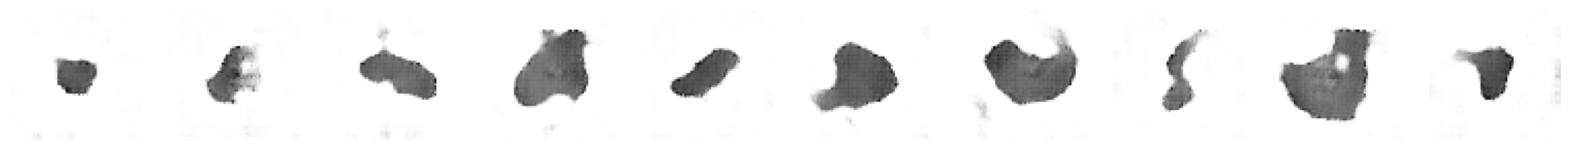

313/313 ━━━━━━━━━━━━━━━━━━━━ 77s 246ms/step - d_acc: 0.8870 - d_fake_acc: 0.8842 - d_loss: 0.1183 - d_real_acc: 0.8897 - g_acc: 0.1158 - g_loss: 3.9516
Epoch 8/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - d_acc: 0.9011 - d_fake_acc: 0.9035 - d_loss: 0.0506 - d_real_acc: 0.8988 - g_acc: 0.0965 - g_loss: 4.2646
Saved to ./output/generated_img_007.png


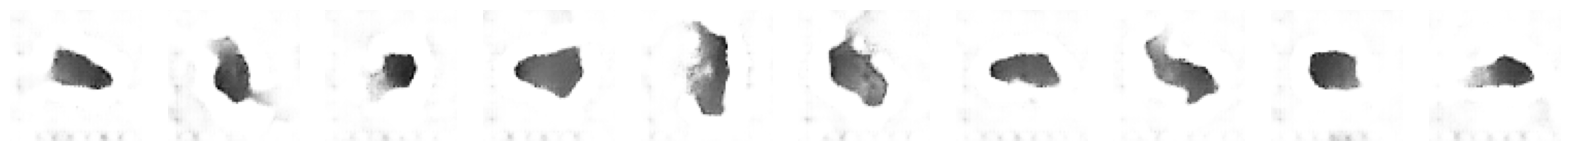

313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 246ms/step - d_acc: 0.9011 - d_fake_acc: 0.9034 - d_loss: 0.0508 - d_real_acc: 0.8987 - g_acc: 0.0966 - g_loss: 4.2650
Epoch 9/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - d_acc: 0.9151 - d_fake_acc: 0.9167 - d_loss: 0.0285 - d_real_acc: 0.9136 - g_acc: 0.0833 - g_loss: 4.5202
Saved to ./output/generated_img_008.png


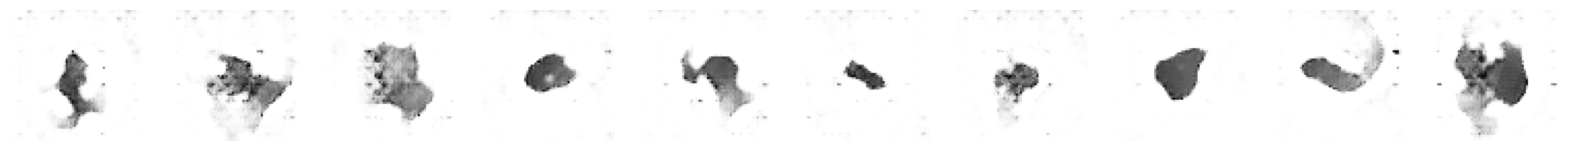

313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 249ms/step - d_acc: 0.9151 - d_fake_acc: 0.9166 - d_loss: 0.0287 - d_real_acc: 0.9135 - g_acc: 0.0834 - g_loss: 4.5197
Epoch 10/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - d_acc: 0.8981 - d_fake_acc: 0.9042 - d_loss: 0.0584 - d_real_acc: 0.8921 - g_acc: 0.0958 - g_loss: 4.6153
Saved to ./output/generated_img_009.png


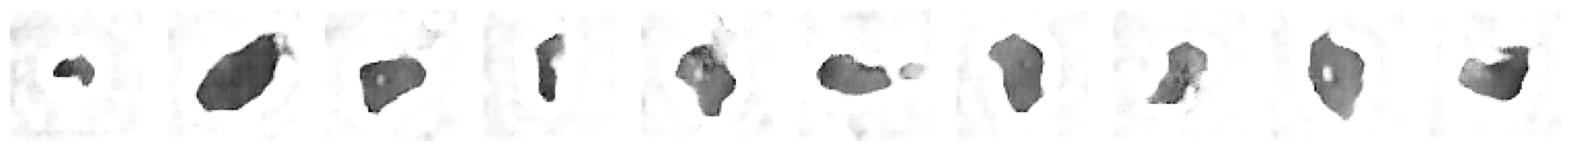

313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 247ms/step - d_acc: 0.8981 - d_fake_acc: 0.9041 - d_loss: 0.0586 - d_real_acc: 0.8921 - g_acc: 0.0959 - g_loss: 4.6145
Epoch 11/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - d_acc: 0.9250 - d_fake_acc: 0.9260 - d_loss: -0.0176 - d_real_acc: 0.9239 - g_acc: 0.0740 - g_loss: 4.7472
Saved to ./output/generated_img_010.png


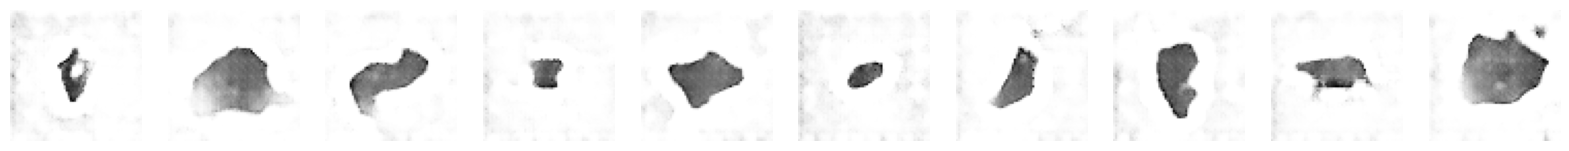

313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 246ms/step - d_acc: 0.9249 - d_fake_acc: 0.9260 - d_loss: -0.0174 - d_real_acc: 0.9239 - g_acc: 0.0740 - g_loss: 4.7474
Epoch 12/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - d_acc: 0.8667 - d_fake_acc: 0.8738 - d_loss: 0.1801 - d_real_acc: 0.8596 - g_acc: 0.1262 - g_loss: 4.3936
Saved to ./output/generated_img_011.png


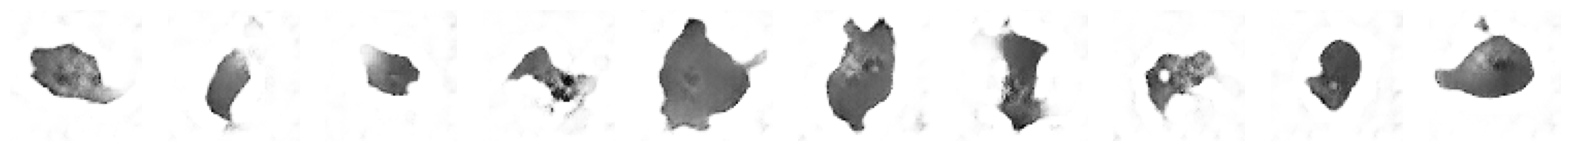

313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 245ms/step - d_acc: 0.8668 - d_fake_acc: 0.8739 - d_loss: 0.1798 - d_real_acc: 0.8597 - g_acc: 0.1261 - g_loss: 4.3940
Epoch 13/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - d_acc: 0.9391 - d_fake_acc: 0.9391 - d_loss: -0.0388 - d_real_acc: 0.9391 - g_acc: 0.0609 - g_loss: 5.1523
Saved to ./output/generated_img_012.png


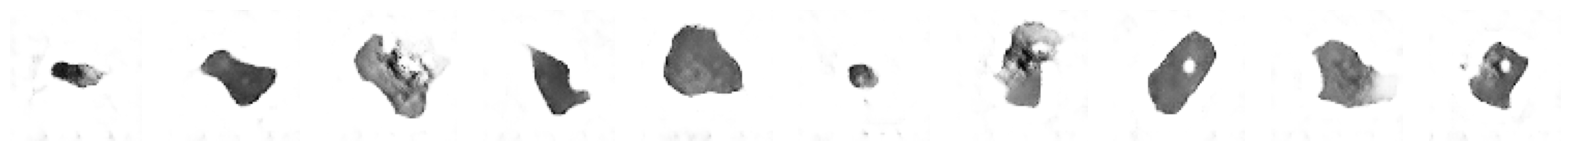

313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 250ms/step - d_acc: 0.9391 - d_fake_acc: 0.9390 - d_loss: -0.0387 - d_real_acc: 0.9391 - g_acc: 0.0610 - g_loss: 5.1526
Epoch 14/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - d_acc: 0.8991 - d_fake_acc: 0.8988 - d_loss: 0.0558 - d_real_acc: 0.8994 - g_acc: 0.1012 - g_loss: 5.2024
Saved to ./output/generated_img_013.png


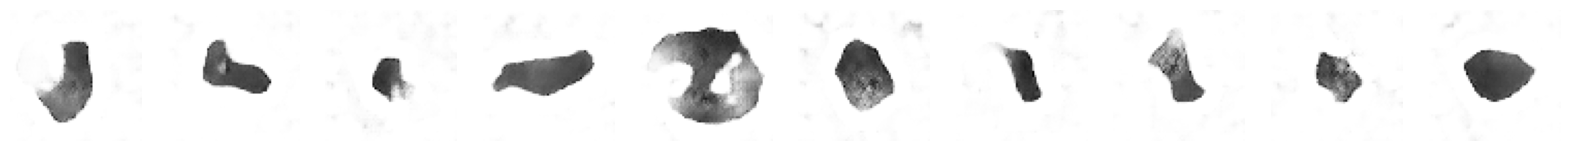

313/313 ━━━━━━━━━━━━━━━━━━━━ 78s 247ms/step - d_acc: 0.8991 - d_fake_acc: 0.8989 - d_loss: 0.0558 - d_real_acc: 0.8994 - g_acc: 0.1011 - g_loss: 5.2022
Epoch 15/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - d_acc: 0.9240 - d_fake_acc: 0.9240 - d_loss: -0.0544 - d_real_acc: 0.9239 - g_acc: 0.0760 - g_loss: 5.5859
Saved to ./output/generated_img_014.png


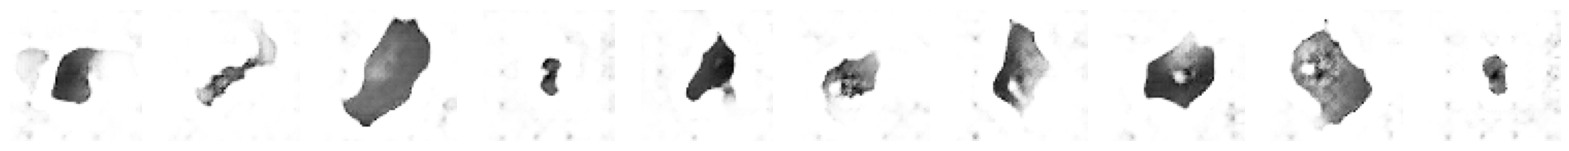

313/313 ━━━━━━━━━━━━━━━━━━━━ 79s 252ms/step - d_acc: 0.9239 - d_fake_acc: 0.9240 - d_loss: -0.0543 - d_real_acc: 0.9239 - g_acc: 0.0760 - g_loss: 5.5855
Epoch 16/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - d_acc: 0.9240 - d_fake_acc: 0.9238 - d_loss: 0.0083 - d_real_acc: 0.9243 - g_acc: 0.0762 - g_loss: 5.3583
Saved to ./output/generated_img_015.png


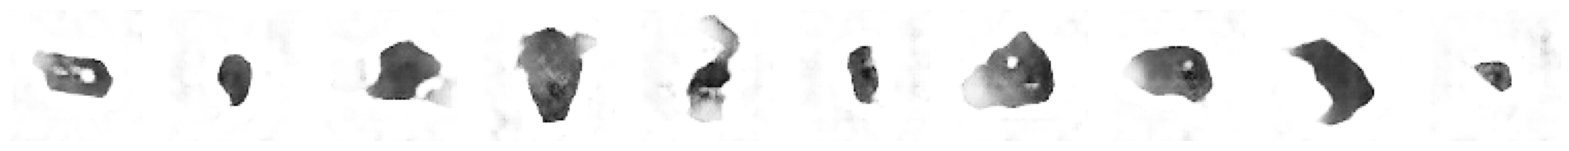

313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 249ms/step - d_acc: 0.9240 - d_fake_acc: 0.9238 - d_loss: 0.0083 - d_real_acc: 0.9243 - g_acc: 0.0762 - g_loss: 5.3583
Epoch 17/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - d_acc: 0.9599 - d_fake_acc: 0.9601 - d_loss: -0.1314 - d_real_acc: 0.9597 - g_acc: 0.0399 - g_loss: 5.9843
Saved to ./output/generated_img_016.png


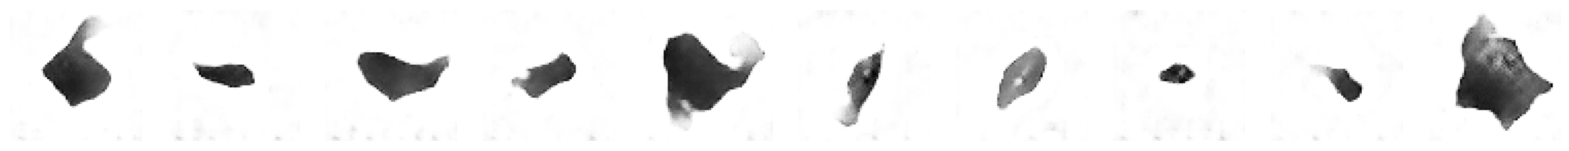

313/313 ━━━━━━━━━━━━━━━━━━━━ 79s 252ms/step - d_acc: 0.9599 - d_fake_acc: 0.9600 - d_loss: -0.1313 - d_real_acc: 0.9597 - g_acc: 0.0400 - g_loss: 5.9846
Epoch 18/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - d_acc: 0.9208 - d_fake_acc: 0.9214 - d_loss: -0.0059 - d_real_acc: 0.9203 - g_acc: 0.0786 - g_loss: 6.0494
Saved to ./output/generated_img_017.png


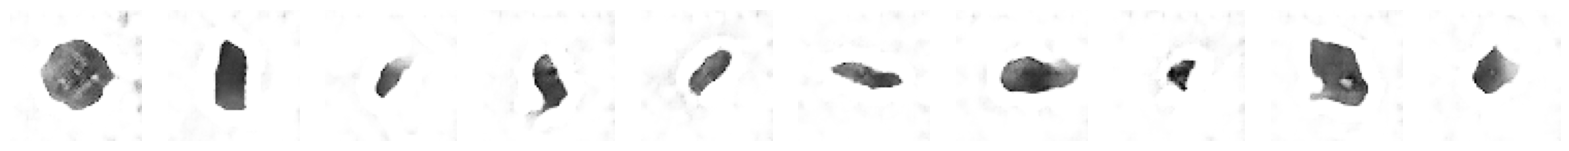

313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 256ms/step - d_acc: 0.9209 - d_fake_acc: 0.9214 - d_loss: -0.0061 - d_real_acc: 0.9203 - g_acc: 0.0786 - g_loss: 6.0494
Epoch 19/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - d_acc: 0.9313 - d_fake_acc: 0.9312 - d_loss: -0.0538 - d_real_acc: 0.9314 - g_acc: 0.0688 - g_loss: 5.7234
Saved to ./output/generated_img_018.png


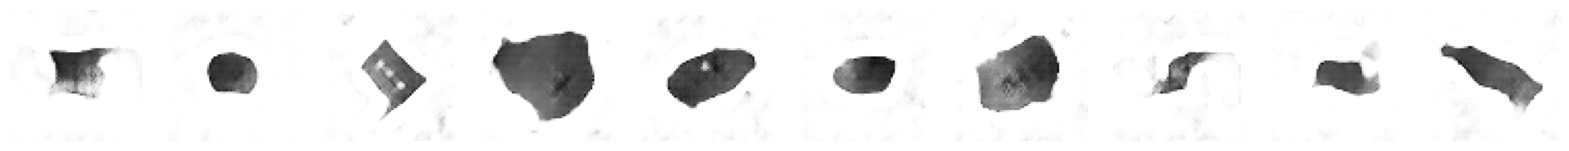

313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 254ms/step - d_acc: 0.9313 - d_fake_acc: 0.9311 - d_loss: -0.0538 - d_real_acc: 0.9314 - g_acc: 0.0689 - g_loss: 5.7233
Epoch 20/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - d_acc: 0.9248 - d_fake_acc: 0.9239 - d_loss: -0.0136 - d_real_acc: 0.9257 - g_acc: 0.0761 - g_loss: 6.1089
Saved to ./output/generated_img_019.png


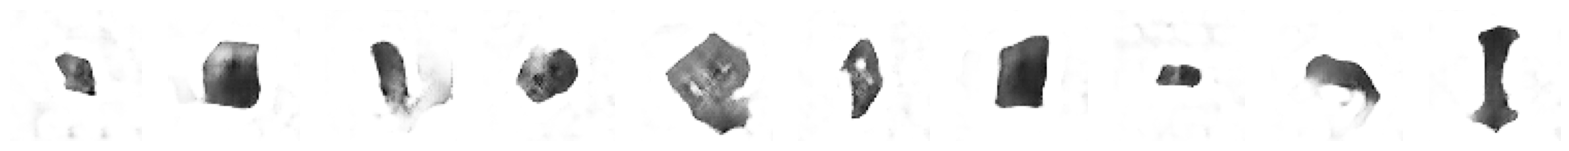

313/313 ━━━━━━━━━━━━━━━━━━━━ 79s 253ms/step - d_acc: 0.9248 - d_fake_acc: 0.9239 - d_loss: -0.0135 - d_real_acc: 0.9257 - g_acc: 0.0761 - g_loss: 6.1086
Epoch 21/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - d_acc: 0.9390 - d_fake_acc: 0.9396 - d_loss: -0.0782 - d_real_acc: 0.9383 - g_acc: 0.0604 - g_loss: 6.2622
Saved to ./output/generated_img_020.png


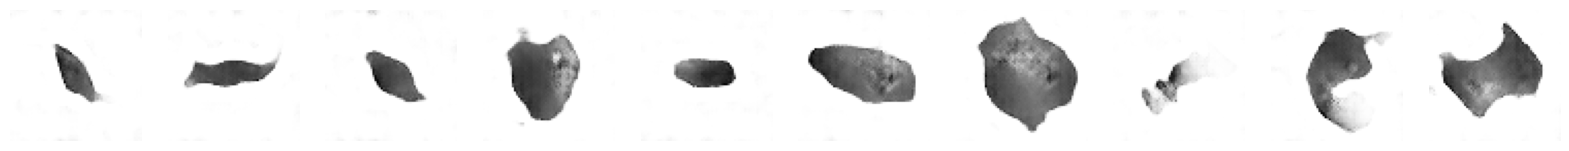

313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 255ms/step - d_acc: 0.9389 - d_fake_acc: 0.9395 - d_loss: -0.0779 - d_real_acc: 0.9382 - g_acc: 0.0605 - g_loss: 6.2611
Epoch 22/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - d_acc: 0.9505 - d_fake_acc: 0.9520 - d_loss: -0.1479 - d_real_acc: 0.9490 - g_acc: 0.0480 - g_loss: 6.5054
Saved to ./output/generated_img_021.png


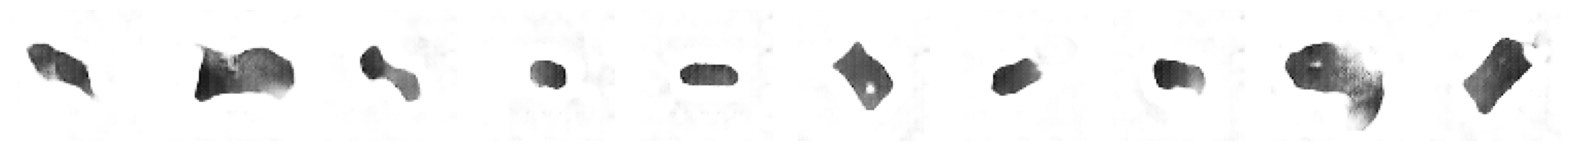

313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 255ms/step - d_acc: 0.9504 - d_fake_acc: 0.9520 - d_loss: -0.1478 - d_real_acc: 0.9489 - g_acc: 0.0480 - g_loss: 6.5058
Epoch 23/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - d_acc: 0.9128 - d_fake_acc: 0.9095 - d_loss: -0.0155 - d_real_acc: 0.9162 - g_acc: 0.0905 - g_loss: 6.3798
Saved to ./output/generated_img_022.png


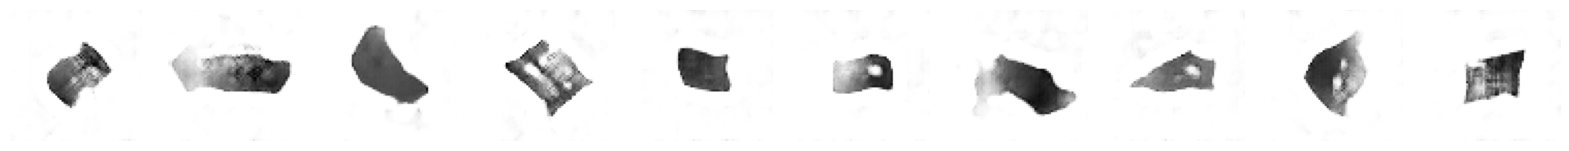

313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 258ms/step - d_acc: 0.9128 - d_fake_acc: 0.9095 - d_loss: -0.0155 - d_real_acc: 0.9162 - g_acc: 0.0905 - g_loss: 6.3795
Epoch 24/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - d_acc: 0.9491 - d_fake_acc: 0.9490 - d_loss: -0.1365 - d_real_acc: 0.9492 - g_acc: 0.0510 - g_loss: 6.6793
Saved to ./output/generated_img_023.png


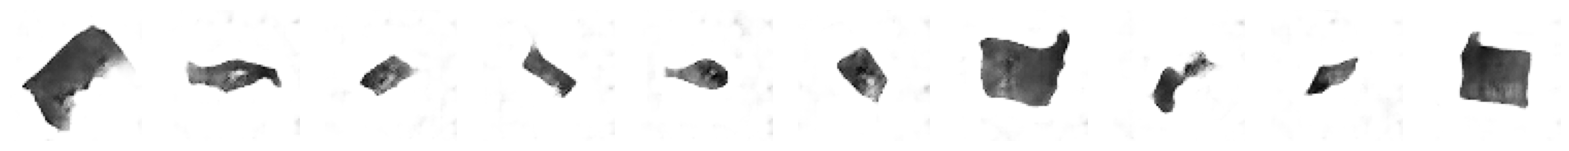

313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 255ms/step - d_acc: 0.9491 - d_fake_acc: 0.9490 - d_loss: -0.1363 - d_real_acc: 0.9491 - g_acc: 0.0510 - g_loss: 6.6788
Epoch 25/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - d_acc: 0.9098 - d_fake_acc: 0.9087 - d_loss: -0.0055 - d_real_acc: 0.9110 - g_acc: 0.0913 - g_loss: 6.6248
Saved to ./output/generated_img_024.png


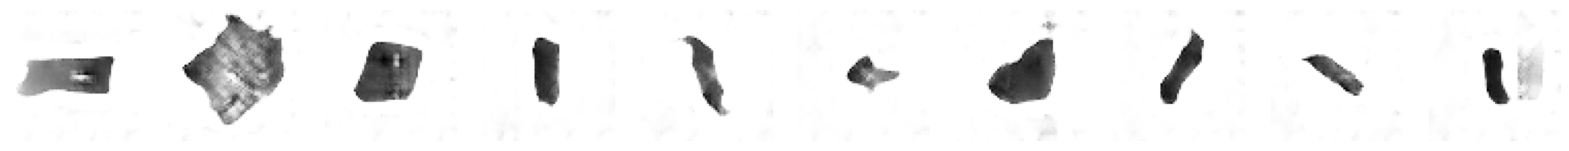

313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 258ms/step - d_acc: 0.9099 - d_fake_acc: 0.9087 - d_loss: -0.0054 - d_real_acc: 0.9110 - g_acc: 0.0913 - g_loss: 6.6261
Epoch 26/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - d_acc: 0.9560 - d_fake_acc: 0.9550 - d_loss: -0.1556 - d_real_acc: 0.9571 - g_acc: 0.0450 - g_loss: 6.6681
Saved to ./output/generated_img_025.png


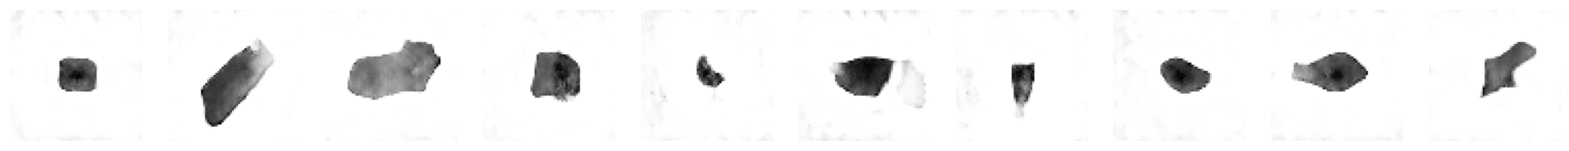

313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 258ms/step - d_acc: 0.9560 - d_fake_acc: 0.9549 - d_loss: -0.1554 - d_real_acc: 0.9571 - g_acc: 0.0451 - g_loss: 6.6684
Epoch 27/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - d_acc: 0.9558 - d_fake_acc: 0.9579 - d_loss: -0.1306 - d_real_acc: 0.9537 - g_acc: 0.0421 - g_loss: 7.0072
Saved to ./output/generated_img_026.png


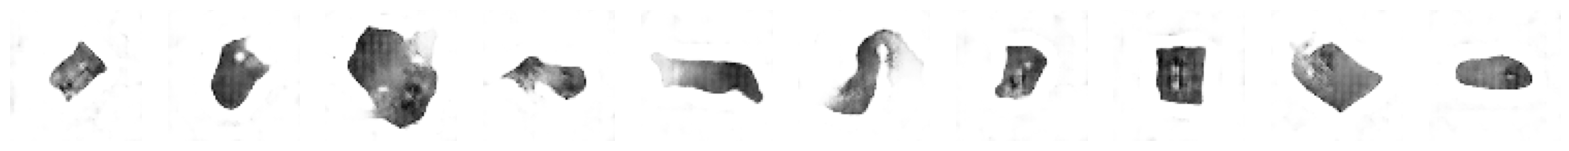

313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 260ms/step - d_acc: 0.9557 - d_fake_acc: 0.9578 - d_loss: -0.1303 - d_real_acc: 0.9536 - g_acc: 0.0422 - g_loss: 7.0067
Epoch 28/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - d_acc: 0.9392 - d_fake_acc: 0.9399 - d_loss: -0.0964 - d_real_acc: 0.9386 - g_acc: 0.0601 - g_loss: 6.9347
Saved to ./output/generated_img_027.png


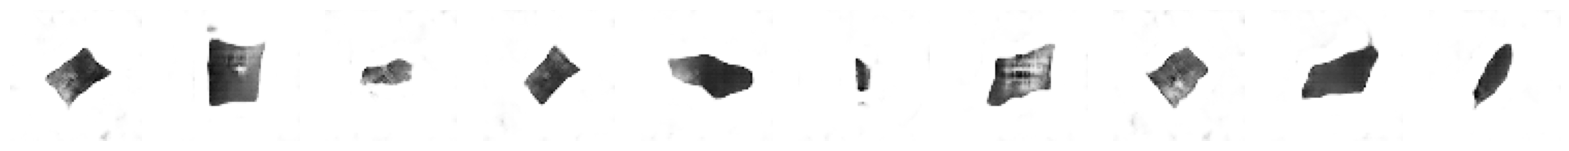

313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 260ms/step - d_acc: 0.9392 - d_fake_acc: 0.9399 - d_loss: -0.0964 - d_real_acc: 0.9386 - g_acc: 0.0601 - g_loss: 6.9347
Epoch 29/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - d_acc: 0.8943 - d_fake_acc: 0.8961 - d_loss: 0.1084 - d_real_acc: 0.8926 - g_acc: 0.1039 - g_loss: 6.4315
Saved to ./output/generated_img_028.png


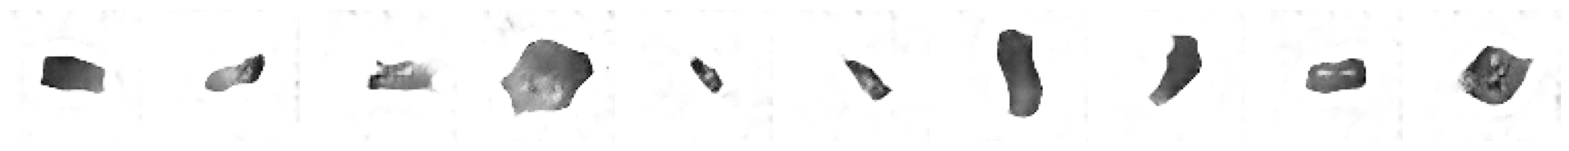

313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 259ms/step - d_acc: 0.8944 - d_fake_acc: 0.8961 - d_loss: 0.1081 - d_real_acc: 0.8927 - g_acc: 0.1039 - g_loss: 6.4322
Epoch 30/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - d_acc: 0.9488 - d_fake_acc: 0.9493 - d_loss: -0.1388 - d_real_acc: 0.9483 - g_acc: 0.0507 - g_loss: 6.8479
Saved to ./output/generated_img_029.png


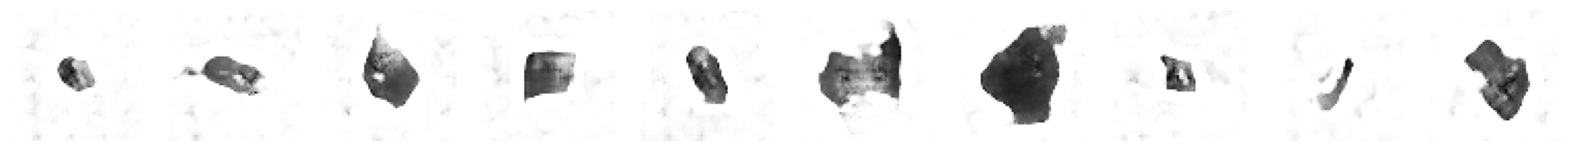

313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 258ms/step - d_acc: 0.9488 - d_fake_acc: 0.9493 - d_loss: -0.1388 - d_real_acc: 0.9483 - g_acc: 0.0507 - g_loss: 6.8493
Epoch 31/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - d_acc: 0.9337 - d_fake_acc: 0.9353 - d_loss: -0.0870 - d_real_acc: 0.9321 - g_acc: 0.0647 - g_loss: 7.2048
Saved to ./output/generated_img_030.png


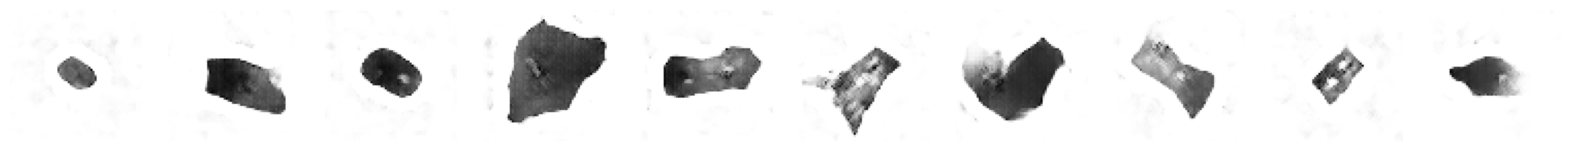

313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 262ms/step - d_acc: 0.9337 - d_fake_acc: 0.9353 - d_loss: -0.0871 - d_real_acc: 0.9321 - g_acc: 0.0647 - g_loss: 7.2043
Epoch 32/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - d_acc: 0.9333 - d_fake_acc: 0.9344 - d_loss: -0.0772 - d_real_acc: 0.9322 - g_acc: 0.0656 - g_loss: 7.6083
Saved to ./output/generated_img_031.png


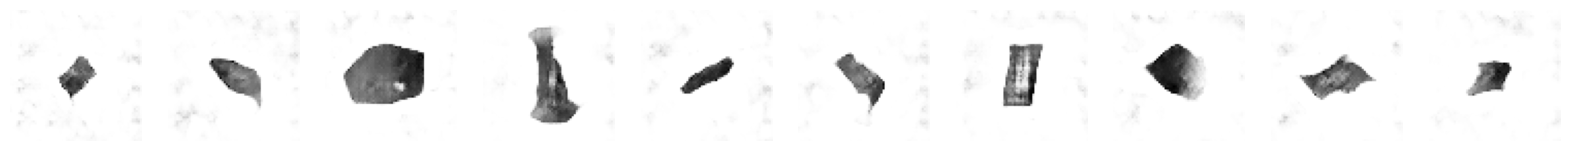

313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 261ms/step - d_acc: 0.9333 - d_fake_acc: 0.9344 - d_loss: -0.0772 - d_real_acc: 0.9321 - g_acc: 0.0656 - g_loss: 7.6065
Epoch 33/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - d_acc: 0.9387 - d_fake_acc: 0.9387 - d_loss: -0.1387 - d_real_acc: 0.9388 - g_acc: 0.0613 - g_loss: 7.4701
Saved to ./output/generated_img_032.png


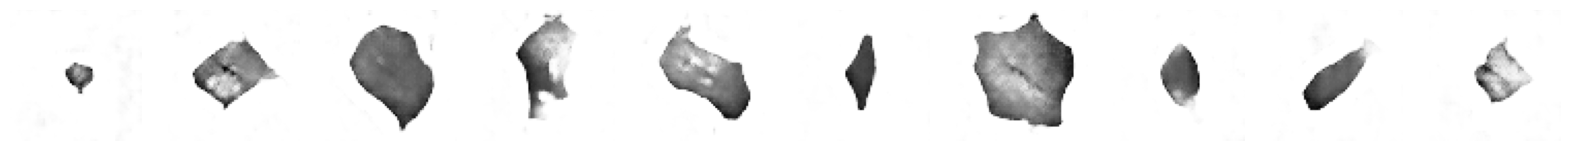

313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 264ms/step - d_acc: 0.9387 - d_fake_acc: 0.9386 - d_loss: -0.1387 - d_real_acc: 0.9387 - g_acc: 0.0614 - g_loss: 7.4706
Epoch 34/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - d_acc: 0.9448 - d_fake_acc: 0.9421 - d_loss: -0.1936 - d_real_acc: 0.9474 - g_acc: 0.0579 - g_loss: 7.7019
Saved to ./output/generated_img_033.png


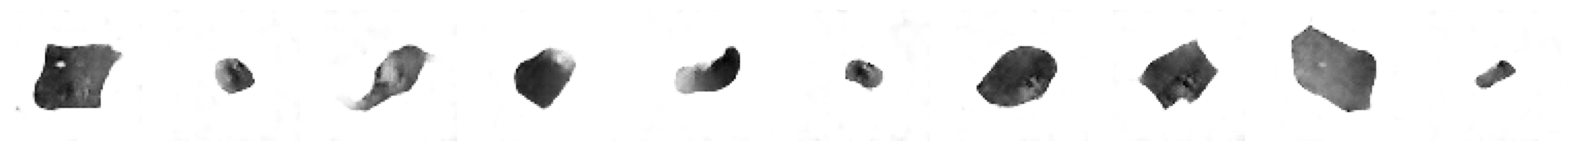

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 263ms/step - d_acc: 0.9448 - d_fake_acc: 0.9421 - d_loss: -0.1936 - d_real_acc: 0.9474 - g_acc: 0.0579 - g_loss: 7.7027
Epoch 35/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - d_acc: 0.9518 - d_fake_acc: 0.9539 - d_loss: -0.2142 - d_real_acc: 0.9497 - g_acc: 0.0461 - g_loss: 8.1366
Saved to ./output/generated_img_034.png


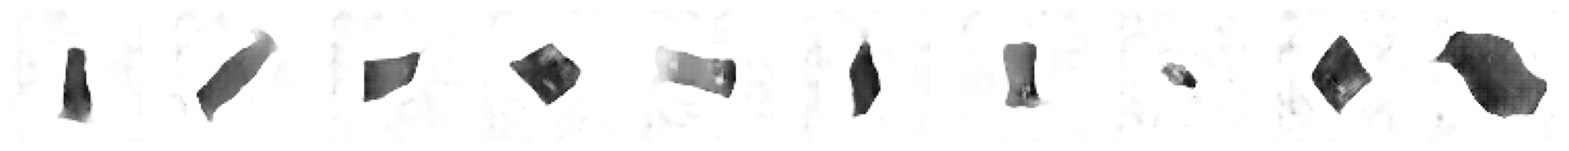

313/313 ━━━━━━━━━━━━━━━━━━━━ 84s 266ms/step - d_acc: 0.9518 - d_fake_acc: 0.9539 - d_loss: -0.2142 - d_real_acc: 0.9497 - g_acc: 0.0461 - g_loss: 8.1363
Epoch 36/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - d_acc: 0.9317 - d_fake_acc: 0.9578 - d_loss: 0.1652 - d_real_acc: 0.9056 - g_acc: 0.0422 - g_loss: 9.9338
Saved to ./output/generated_img_035.png


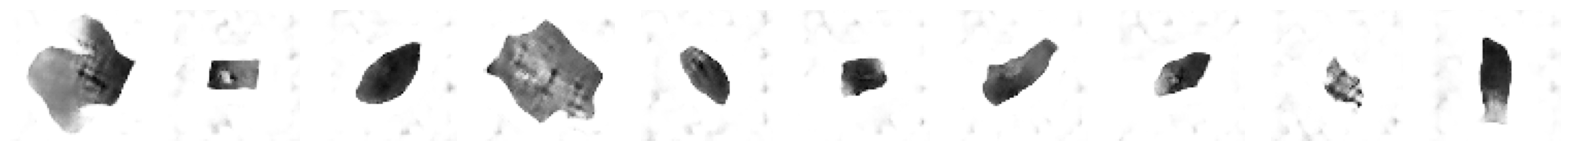

313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 263ms/step - d_acc: 0.9317 - d_fake_acc: 0.9577 - d_loss: 0.1651 - d_real_acc: 0.9056 - g_acc: 0.0423 - g_loss: 9.9314
Epoch 37/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - d_acc: 0.9691 - d_fake_acc: 0.9709 - d_loss: -0.3312 - d_real_acc: 0.9673 - g_acc: 0.0291 - g_loss: 9.0595
Saved to ./output/generated_img_036.png


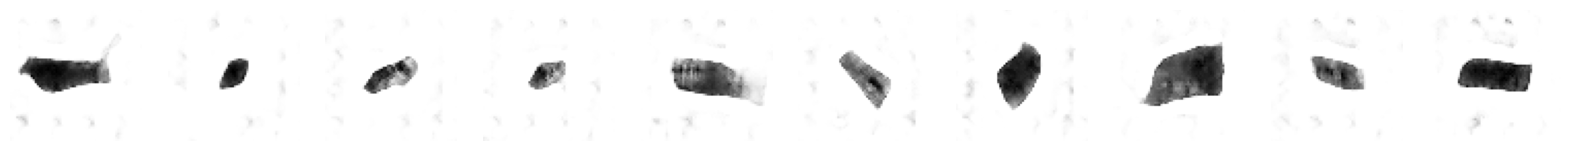

313/313 ━━━━━━━━━━━━━━━━━━━━ 144s 268ms/step - d_acc: 0.9691 - d_fake_acc: 0.9709 - d_loss: -0.3311 - d_real_acc: 0.9673 - g_acc: 0.0291 - g_loss: 9.0601
Epoch 38/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - d_acc: 0.9514 - d_fake_acc: 0.9528 - d_loss: -0.2188 - d_real_acc: 0.9501 - g_acc: 0.0472 - g_loss: 8.2270
Saved to ./output/generated_img_037.png


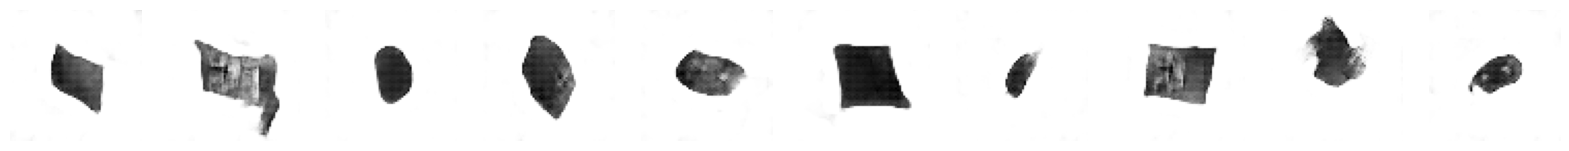

313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 266ms/step - d_acc: 0.9515 - d_fake_acc: 0.9528 - d_loss: -0.2190 - d_real_acc: 0.9501 - g_acc: 0.0472 - g_loss: 8.2295
Epoch 39/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - d_acc: 0.9239 - d_fake_acc: 0.9254 - d_loss: -0.0857 - d_real_acc: 0.9223 - g_acc: 0.0746 - g_loss: 7.8606
Saved to ./output/generated_img_038.png


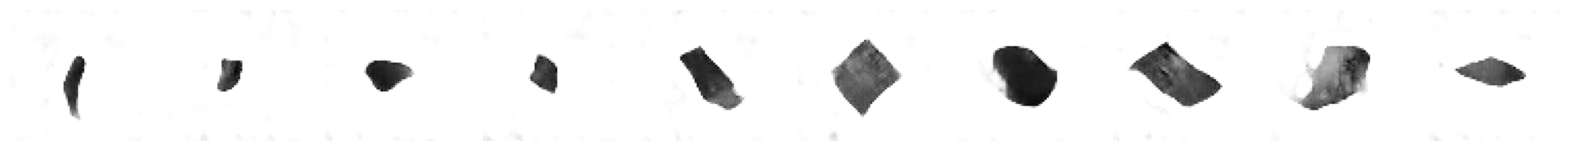

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 268ms/step - d_acc: 0.9239 - d_fake_acc: 0.9255 - d_loss: -0.0861 - d_real_acc: 0.9224 - g_acc: 0.0745 - g_loss: 7.8627
Epoch 40/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - d_acc: 0.9254 - d_fake_acc: 0.9351 - d_loss: 0.0384 - d_real_acc: 0.9158 - g_acc: 0.0649 - g_loss: 8.6326
Saved to ./output/generated_img_039.png


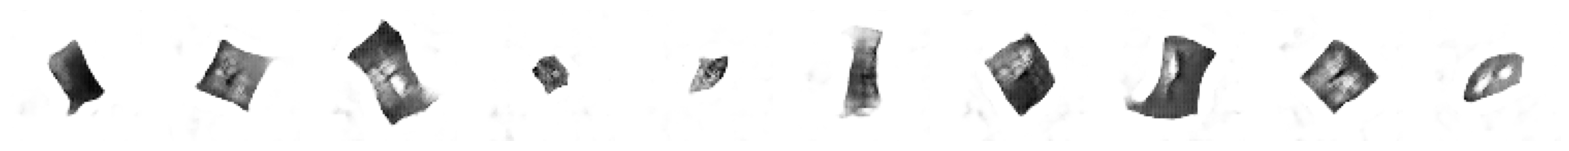

313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 266ms/step - d_acc: 0.9255 - d_fake_acc: 0.9351 - d_loss: 0.0379 - d_real_acc: 0.9158 - g_acc: 0.0649 - g_loss: 8.6327
Epoch 41/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - d_acc: 0.9432 - d_fake_acc: 0.9437 - d_loss: -0.2227 - d_real_acc: 0.9427 - g_acc: 0.0563 - g_loss: 9.0428
Saved to ./output/generated_img_040.png


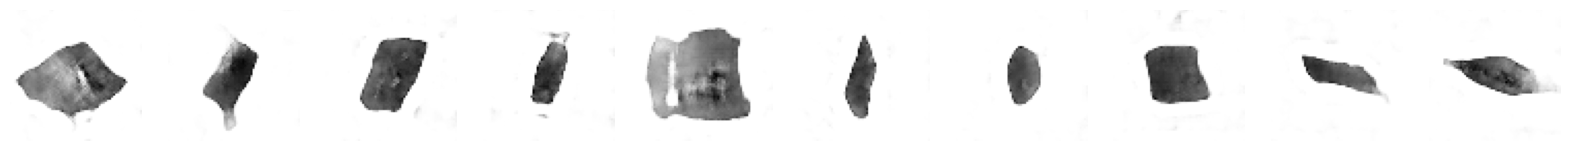

313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 271ms/step - d_acc: 0.9432 - d_fake_acc: 0.9437 - d_loss: -0.2227 - d_real_acc: 0.9427 - g_acc: 0.0563 - g_loss: 9.0431
Epoch 42/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - d_acc: 0.9300 - d_fake_acc: 0.9321 - d_loss: -0.1160 - d_real_acc: 0.9280 - g_acc: 0.0679 - g_loss: 8.3248
Saved to ./output/generated_img_041.png


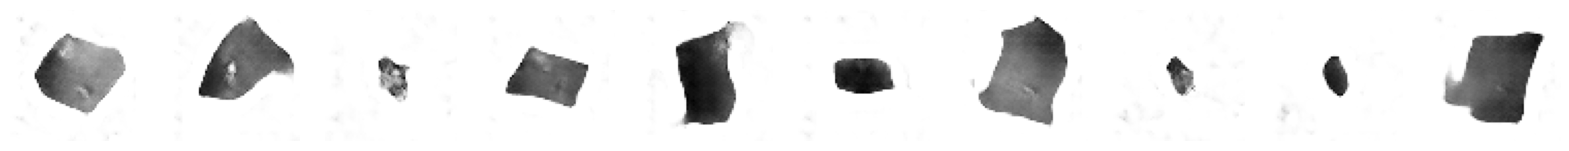

313/313 ━━━━━━━━━━━━━━━━━━━━ 140s 266ms/step - d_acc: 0.9301 - d_fake_acc: 0.9321 - d_loss: -0.1161 - d_real_acc: 0.9280 - g_acc: 0.0679 - g_loss: 8.3258
Epoch 43/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - d_acc: 0.9306 - d_fake_acc: 0.9347 - d_loss: -0.1316 - d_real_acc: 0.9265 - g_acc: 0.0653 - g_loss: 8.6216
Saved to ./output/generated_img_042.png


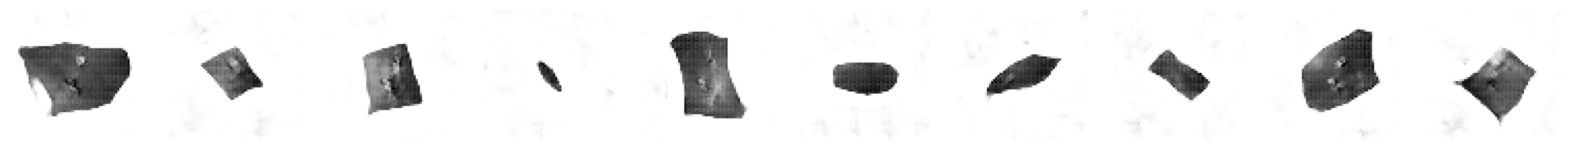

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 267ms/step - d_acc: 0.9307 - d_fake_acc: 0.9348 - d_loss: -0.1320 - d_real_acc: 0.9265 - g_acc: 0.0652 - g_loss: 8.6238
Epoch 44/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - d_acc: 0.9590 - d_fake_acc: 0.9614 - d_loss: -0.3328 - d_real_acc: 0.9566 - g_acc: 0.0386 - g_loss: 10.9150
Saved to ./output/generated_img_043.png


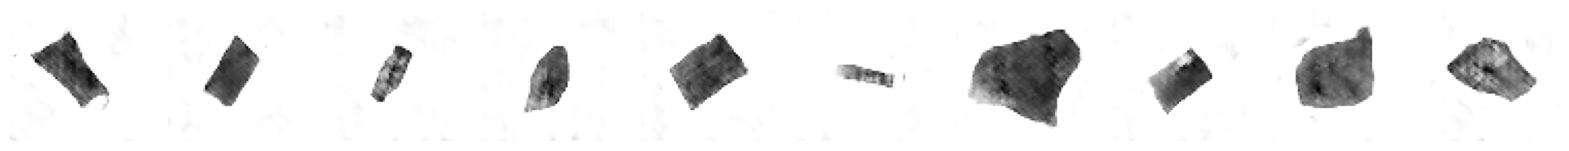

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 267ms/step - d_acc: 0.9590 - d_fake_acc: 0.9614 - d_loss: -0.3325 - d_real_acc: 0.9565 - g_acc: 0.0386 - g_loss: 10.9125
Epoch 45/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - d_acc: 0.9409 - d_fake_acc: 0.9414 - d_loss: -0.2387 - d_real_acc: 0.9405 - g_acc: 0.0586 - g_loss: 9.3184
Saved to ./output/generated_img_044.png


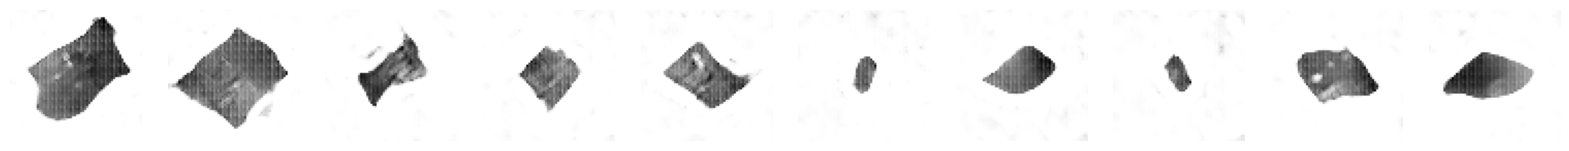

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 269ms/step - d_acc: 0.9410 - d_fake_acc: 0.9415 - d_loss: -0.2394 - d_real_acc: 0.9406 - g_acc: 0.0585 - g_loss: 9.3261
Epoch 46/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - d_acc: 0.9395 - d_fake_acc: 0.9396 - d_loss: -0.2405 - d_real_acc: 0.9395 - g_acc: 0.0604 - g_loss: 9.7856
Saved to ./output/generated_img_045.png


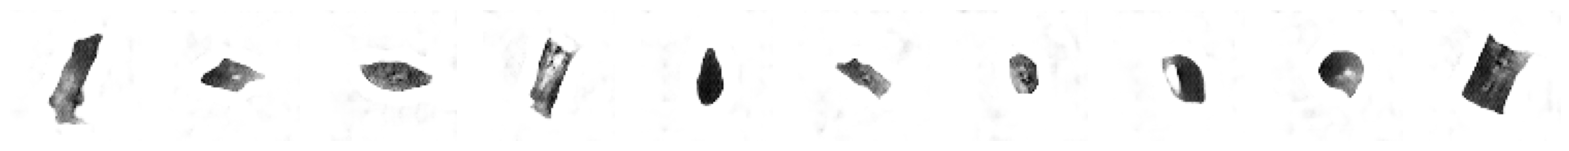

313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 274ms/step - d_acc: 0.9396 - d_fake_acc: 0.9396 - d_loss: -0.2407 - d_real_acc: 0.9395 - g_acc: 0.0604 - g_loss: 9.7859
Epoch 47/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - d_acc: 0.9556 - d_fake_acc: 0.9608 - d_loss: -0.2500 - d_real_acc: 0.9505 - g_acc: 0.0392 - g_loss: 10.2393
Saved to ./output/generated_img_046.png


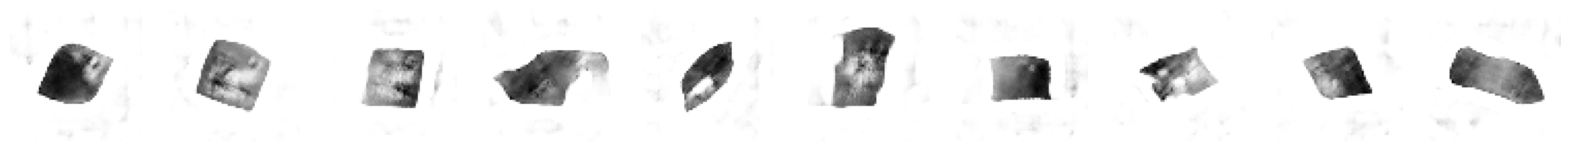

313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 277ms/step - d_acc: 0.9556 - d_fake_acc: 0.9607 - d_loss: -0.2496 - d_real_acc: 0.9504 - g_acc: 0.0393 - g_loss: 10.2386
Epoch 48/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - d_acc: 0.9834 - d_fake_acc: 0.9830 - d_loss: -0.5532 - d_real_acc: 0.9839 - g_acc: 0.0170 - g_loss: 12.1450
Saved to ./output/generated_img_047.png


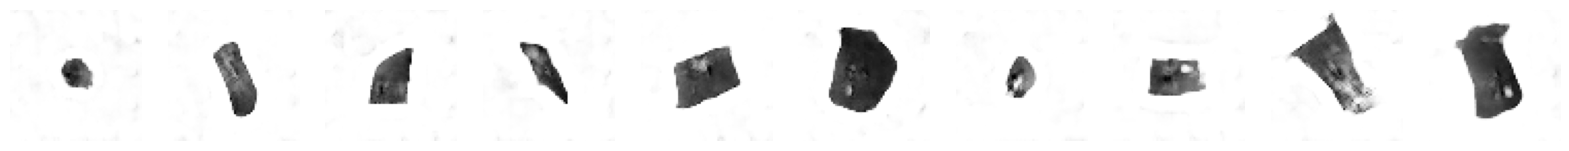

313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 274ms/step - d_acc: 0.9834 - d_fake_acc: 0.9830 - d_loss: -0.5533 - d_real_acc: 0.9839 - g_acc: 0.0170 - g_loss: 12.1488
Epoch 49/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - d_acc: 0.9459 - d_fake_acc: 0.9517 - d_loss: -0.1887 - d_real_acc: 0.9401 - g_acc: 0.0483 - g_loss: 9.9460
Saved to ./output/generated_img_048.png


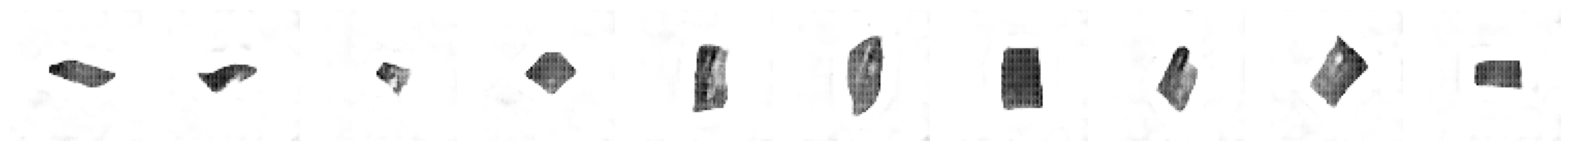

313/313 ━━━━━━━━━━━━━━━━━━━━ 87s 277ms/step - d_acc: 0.9459 - d_fake_acc: 0.9518 - d_loss: -0.1891 - d_real_acc: 0.9401 - g_acc: 0.0482 - g_loss: 9.9501
Epoch 50/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - d_acc: 0.9894 - d_fake_acc: 0.9899 - d_loss: -0.7060 - d_real_acc: 0.9889 - g_acc: 0.0101 - g_loss: 15.3854
Saved to ./output/generated_img_049.png


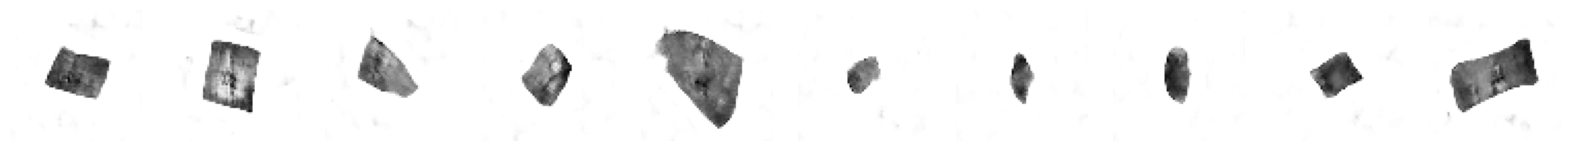

313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 276ms/step - d_acc: 0.9893 - d_fake_acc: 0.9898 - d_loss: -0.7050 - d_real_acc: 0.9888 - g_acc: 0.0102 - g_loss: 15.3771
Epoch 51/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - d_acc: 0.9571 - d_fake_acc: 0.9572 - d_loss: -0.3570 - d_real_acc: 0.9569 - g_acc: 0.0428 - g_loss: 10.5397
Saved to ./output/generated_img_050.png


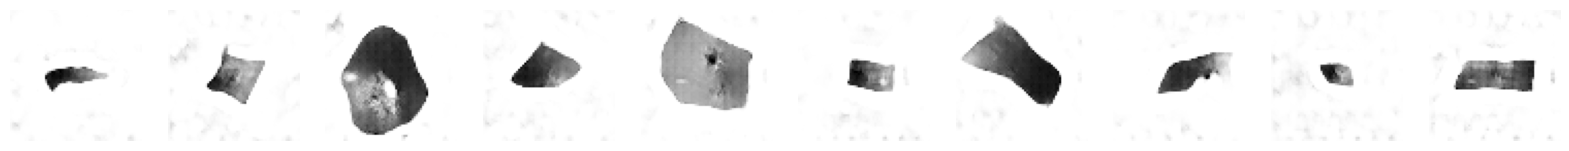

313/313 ━━━━━━━━━━━━━━━━━━━━ 87s 277ms/step - d_acc: 0.9571 - d_fake_acc: 0.9572 - d_loss: -0.3569 - d_real_acc: 0.9569 - g_acc: 0.0428 - g_loss: 10.5386
Epoch 52/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - d_acc: 0.9523 - d_fake_acc: 0.9539 - d_loss: -0.3172 - d_real_acc: 0.9508 - g_acc: 0.0461 - g_loss: 10.4026
Saved to ./output/generated_img_051.png


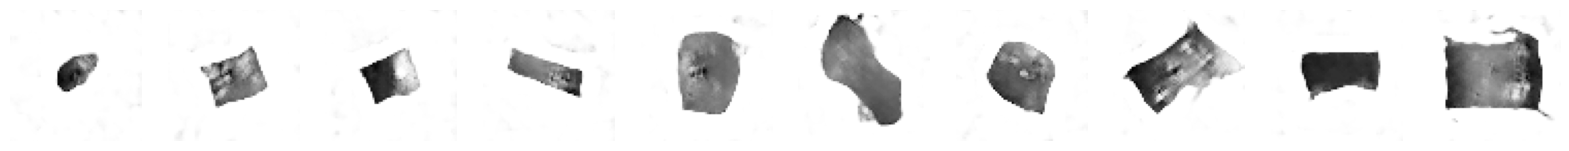

313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 282ms/step - d_acc: 0.9524 - d_fake_acc: 0.9539 - d_loss: -0.3174 - d_real_acc: 0.9508 - g_acc: 0.0461 - g_loss: 10.4037
Epoch 53/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - d_acc: 0.9650 - d_fake_acc: 0.9655 - d_loss: -0.3429 - d_real_acc: 0.9646 - g_acc: 0.0345 - g_loss: 10.2126
Saved to ./output/generated_img_052.png


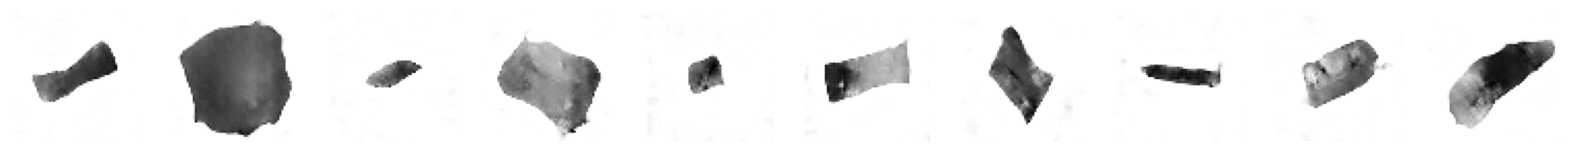

313/313 ━━━━━━━━━━━━━━━━━━━━ 140s 277ms/step - d_acc: 0.9650 - d_fake_acc: 0.9655 - d_loss: -0.3430 - d_real_acc: 0.9646 - g_acc: 0.0345 - g_loss: 10.2151
Epoch 54/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - d_acc: 0.9787 - d_fake_acc: 0.9786 - d_loss: -0.5341 - d_real_acc: 0.9788 - g_acc: 0.0214 - g_loss: 12.5000
Saved to ./output/generated_img_053.png


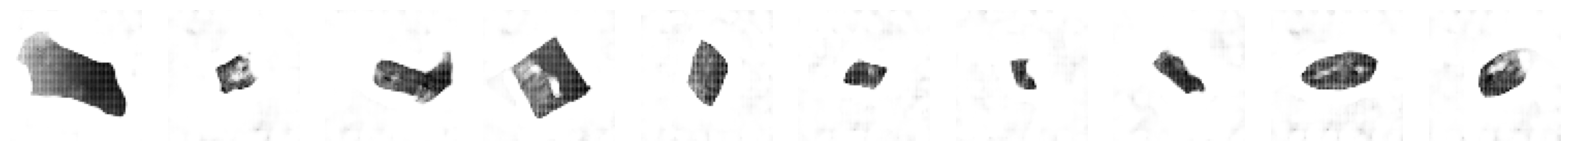

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 278ms/step - d_acc: 0.9787 - d_fake_acc: 0.9786 - d_loss: -0.5345 - d_real_acc: 0.9788 - g_acc: 0.0214 - g_loss: 12.5053
Epoch 55/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8023 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1180
Saved to ./output/generated_img_054.png


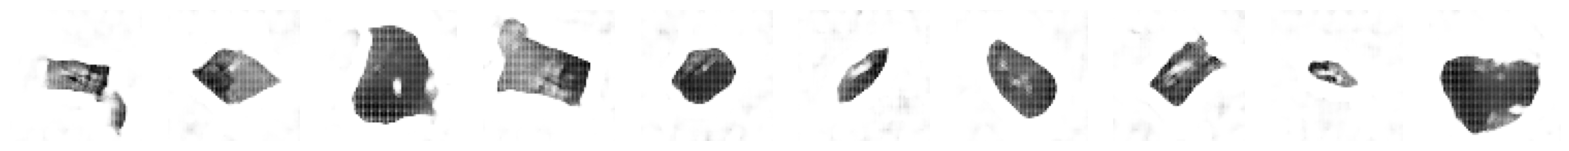

313/313 ━━━━━━━━━━━━━━━━━━━━ 89s 282ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8023 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1180
Epoch 56/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8016 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1179
Saved to ./output/generated_img_055.png


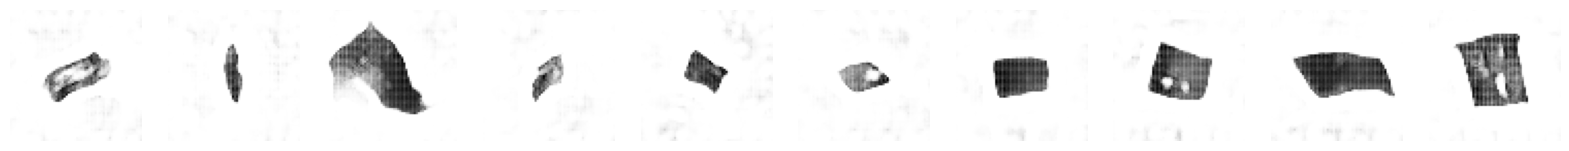

313/313 ━━━━━━━━━━━━━━━━━━━━ 140s 277ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8016 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1179
Epoch 57/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.7976 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1179
Saved to ./output/generated_img_056.png


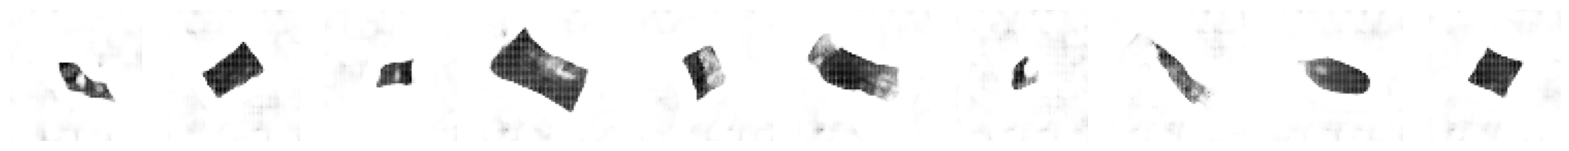

313/313 ━━━━━━━━━━━━━━━━━━━━ 88s 279ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.7976 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1179
Epoch 58/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8000 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1175
Saved to ./output/generated_img_057.png


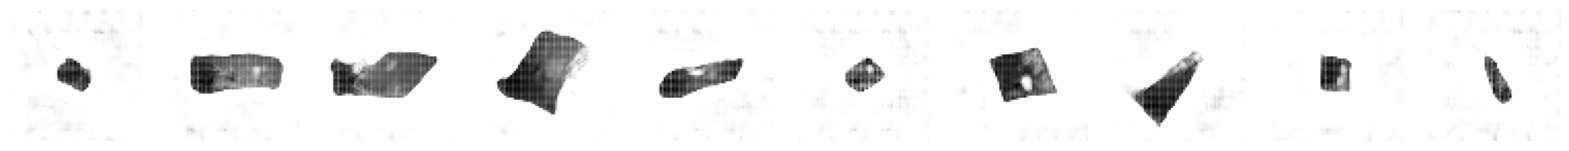

313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 284ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8000 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1175
Epoch 59/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8040 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1170
Saved to ./output/generated_img_058.png


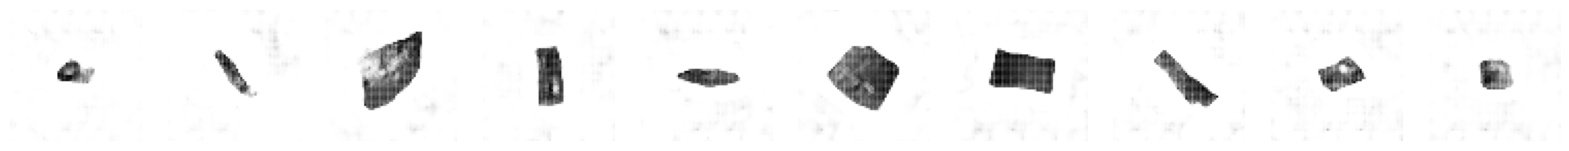

313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 282ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8040 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1170
Epoch 60/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8000 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1024
Saved to ./output/generated_img_059.png


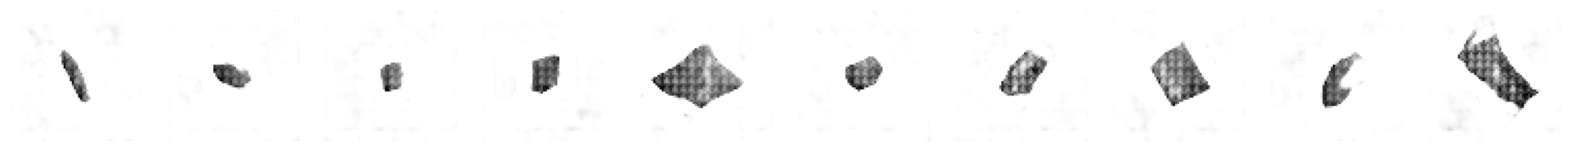

313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 279ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8000 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1023
Epoch 61/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8010 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1173
Saved to ./output/generated_img_060.png


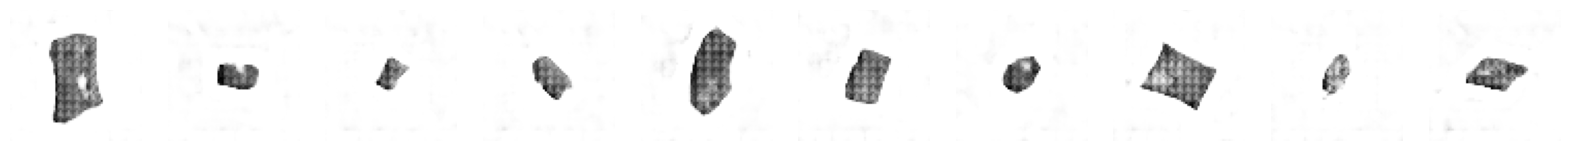

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 279ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8010 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1173
Epoch 62/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - d_acc: 0.7764 - d_fake_acc: 0.5572 - d_loss: 3.1102 - d_real_acc: 0.9956 - g_acc: 0.4428 - g_loss: 8.9141
Saved to ./output/generated_img_061.png


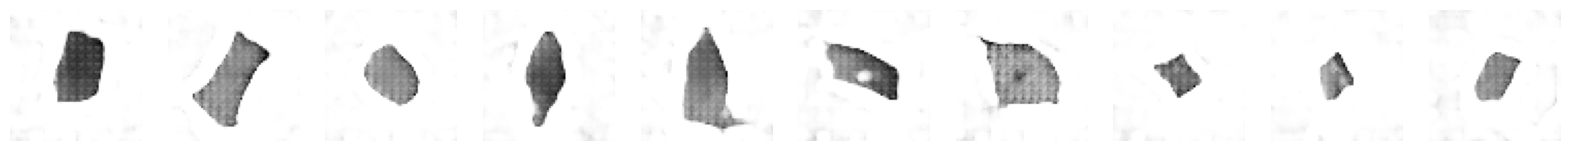

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 280ms/step - d_acc: 0.7759 - d_fake_acc: 0.5561 - d_loss: 3.1195 - d_real_acc: 0.9956 - g_acc: 0.4439 - g_loss: 8.8971
Epoch 63/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - d_acc: 0.5000 - d_fake_acc: 0.0000e+00 - d_loss: 7.9728 - d_real_acc: 1.0000 - g_acc: 1.0000 - g_loss: 1.1921e-07
Saved to ./output/generated_img_062.png


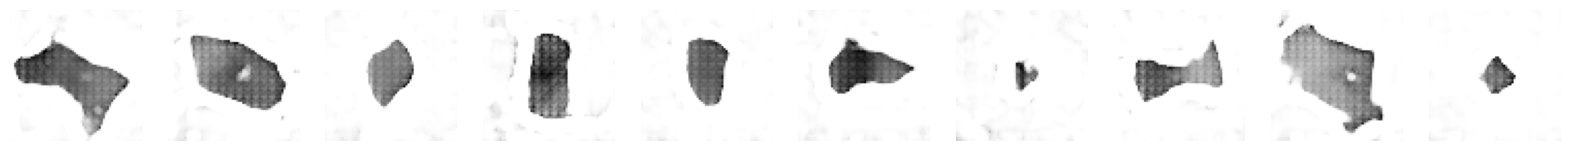

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 280ms/step - d_acc: 0.5000 - d_fake_acc: 0.0000e+00 - d_loss: 7.9728 - d_real_acc: 1.0000 - g_acc: 1.0000 - g_loss: 1.1921e-07
Epoch 64/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - d_acc: 0.5000 - d_fake_acc: 0.0000e+00 - d_loss: 7.9690 - d_real_acc: 1.0000 - g_acc: 1.0000 - g_loss: 1.1921e-07
Saved to ./output/generated_img_063.png


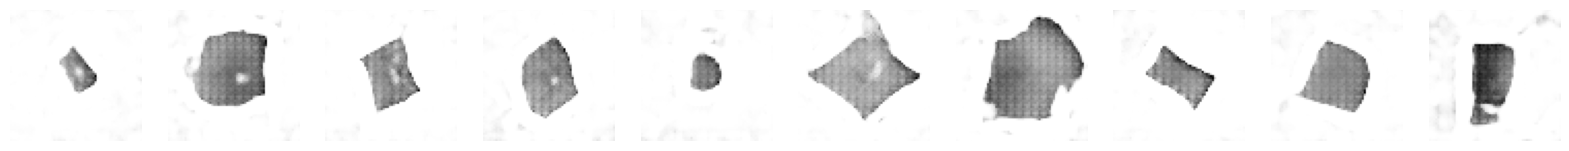

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 281ms/step - d_acc: 0.5000 - d_fake_acc: 0.0000e+00 - d_loss: 7.9690 - d_real_acc: 1.0000 - g_acc: 1.0000 - g_loss: 1.1921e-07
Epoch 65/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - d_acc: 0.5456 - d_fake_acc: 0.1723 - d_loss: 6.5121 - d_real_acc: 0.9188 - g_acc: 0.8277 - g_loss: 1.5492
Saved to ./output/generated_img_064.png


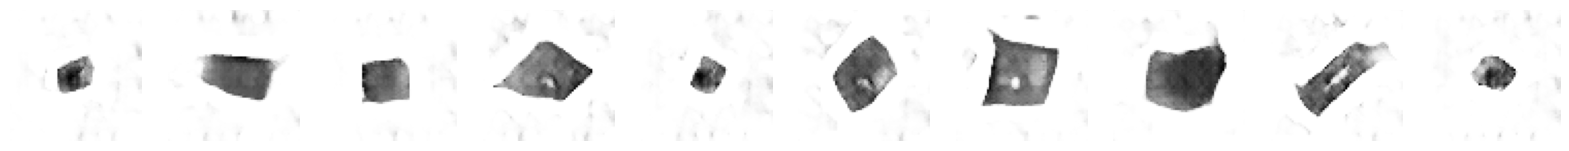

313/313 ━━━━━━━━━━━━━━━━━━━━ 89s 284ms/step - d_acc: 0.5459 - d_fake_acc: 0.1732 - d_loss: 6.5041 - d_real_acc: 0.9185 - g_acc: 0.8268 - g_loss: 1.5567
Epoch 66/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - d_acc: 0.8809 - d_fake_acc: 0.8791 - d_loss: 0.1566 - d_real_acc: 0.8828 - g_acc: 0.1209 - g_loss: 7.1489
Saved to ./output/generated_img_065.png


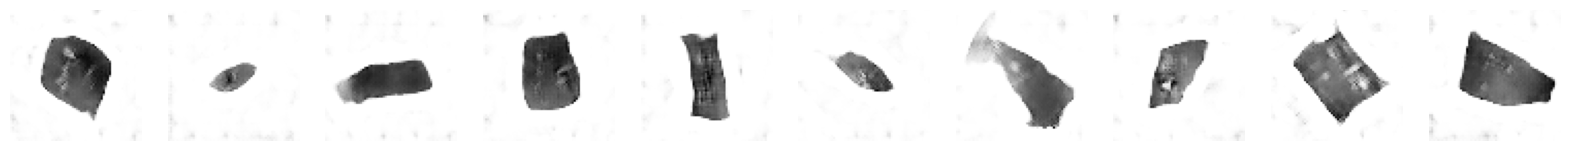

313/313 ━━━━━━━━━━━━━━━━━━━━ 90s 285ms/step - d_acc: 0.8810 - d_fake_acc: 0.8792 - d_loss: 0.1561 - d_real_acc: 0.8829 - g_acc: 0.1208 - g_loss: 7.1504
Epoch 67/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - d_acc: 0.9276 - d_fake_acc: 0.9307 - d_loss: -0.0727 - d_real_acc: 0.9246 - g_acc: 0.0693 - g_loss: 8.1555
Saved to ./output/generated_img_066.png


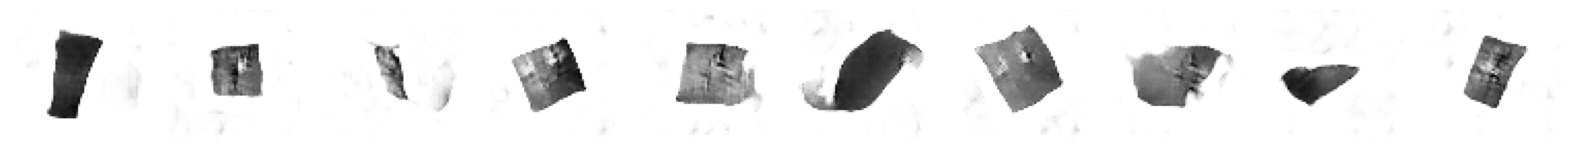

313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 282ms/step - d_acc: 0.9276 - d_fake_acc: 0.9307 - d_loss: -0.0727 - d_real_acc: 0.9246 - g_acc: 0.0693 - g_loss: 8.1549
Epoch 68/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - d_acc: 0.9604 - d_fake_acc: 0.9614 - d_loss: -0.3134 - d_real_acc: 0.9594 - g_acc: 0.0386 - g_loss: 9.5723
Saved to ./output/generated_img_067.png


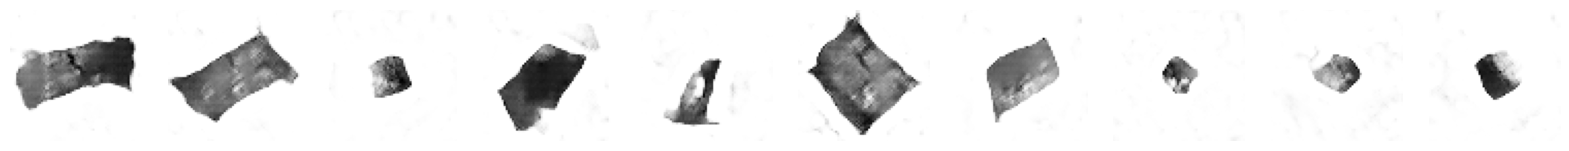

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 281ms/step - d_acc: 0.9604 - d_fake_acc: 0.9614 - d_loss: -0.3133 - d_real_acc: 0.9594 - g_acc: 0.0386 - g_loss: 9.5725
Epoch 69/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - d_acc: 0.9584 - d_fake_acc: 0.9589 - d_loss: -0.3122 - d_real_acc: 0.9579 - g_acc: 0.0411 - g_loss: 9.9643
Saved to ./output/generated_img_068.png


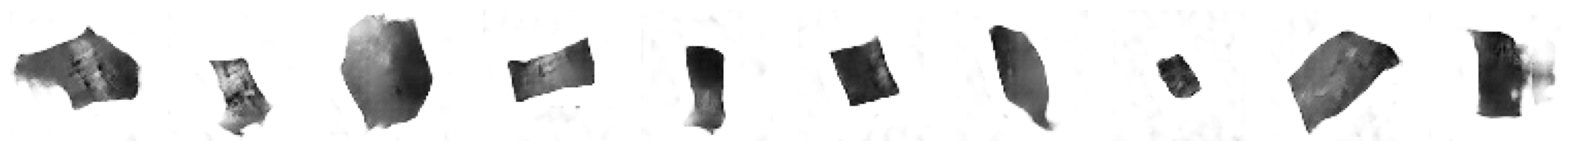

313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 284ms/step - d_acc: 0.9584 - d_fake_acc: 0.9588 - d_loss: -0.3121 - d_real_acc: 0.9579 - g_acc: 0.0412 - g_loss: 9.9626
Epoch 70/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - d_acc: 0.9678 - d_fake_acc: 0.9674 - d_loss: -0.4399 - d_real_acc: 0.9682 - g_acc: 0.0326 - g_loss: 11.4788
Saved to ./output/generated_img_069.png


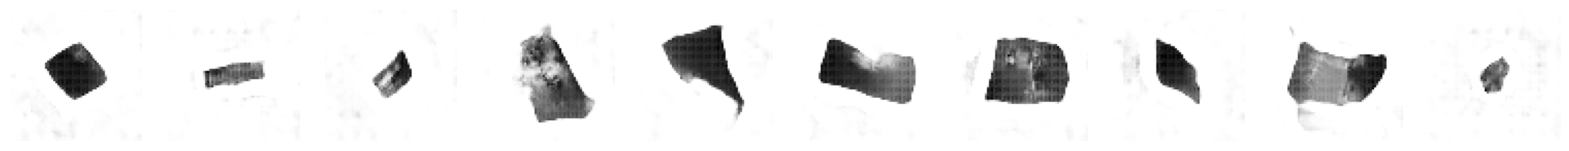

313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 279ms/step - d_acc: 0.9678 - d_fake_acc: 0.9674 - d_loss: -0.4400 - d_real_acc: 0.9682 - g_acc: 0.0326 - g_loss: 11.4799
Epoch 71/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - d_acc: 0.9318 - d_fake_acc: 0.9327 - d_loss: -0.1700 - d_real_acc: 0.9308 - g_acc: 0.0673 - g_loss: 10.3522
Saved to ./output/generated_img_070.png


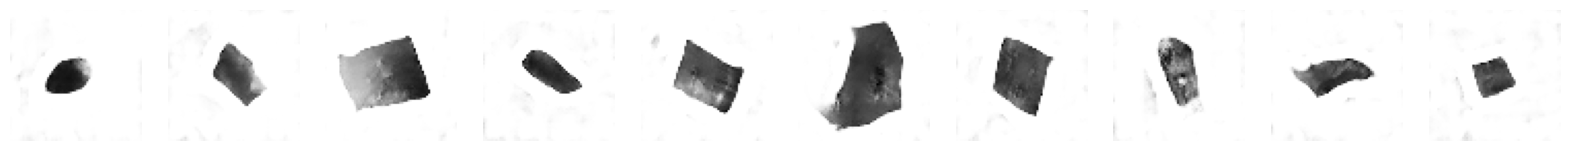

313/313 ━━━━━━━━━━━━━━━━━━━━ 145s 290ms/step - d_acc: 0.9318 - d_fake_acc: 0.9327 - d_loss: -0.1704 - d_real_acc: 0.9309 - g_acc: 0.0673 - g_loss: 10.3526
Epoch 72/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - d_acc: 0.9741 - d_fake_acc: 0.9748 - d_loss: -0.4467 - d_real_acc: 0.9735 - g_acc: 0.0252 - g_loss: 10.7891
Saved to ./output/generated_img_071.png


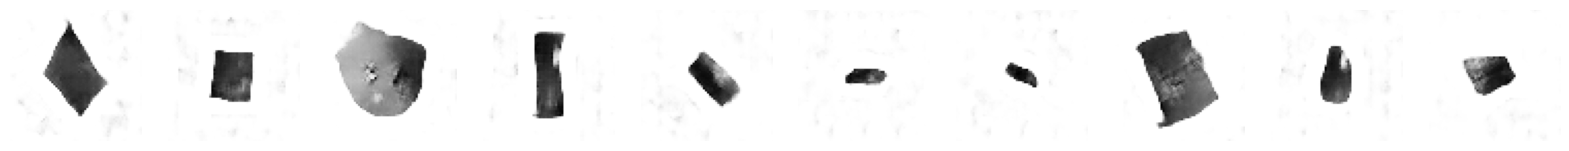

313/313 ━━━━━━━━━━━━━━━━━━━━ 140s 284ms/step - d_acc: 0.9741 - d_fake_acc: 0.9747 - d_loss: -0.4467 - d_real_acc: 0.9735 - g_acc: 0.0253 - g_loss: 10.7904
Epoch 73/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - d_acc: 0.9464 - d_fake_acc: 0.9483 - d_loss: -0.2075 - d_real_acc: 0.9445 - g_acc: 0.0517 - g_loss: 9.6530
Saved to ./output/generated_img_072.png


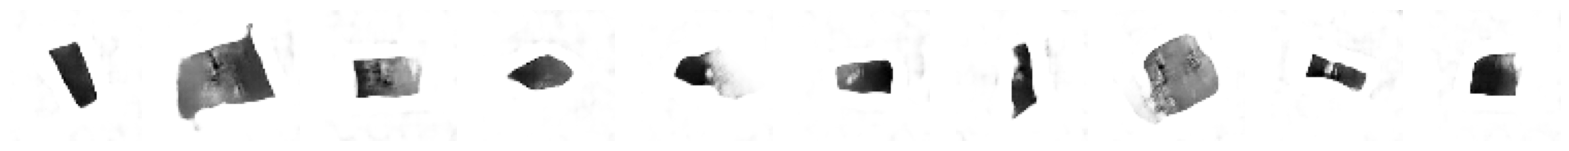

313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 289ms/step - d_acc: 0.9464 - d_fake_acc: 0.9483 - d_loss: -0.2078 - d_real_acc: 0.9446 - g_acc: 0.0517 - g_loss: 9.6543
Epoch 74/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - d_acc: 0.9696 - d_fake_acc: 0.9756 - d_loss: -0.4067 - d_real_acc: 0.9636 - g_acc: 0.0244 - g_loss: 12.4090
Saved to ./output/generated_img_073.png


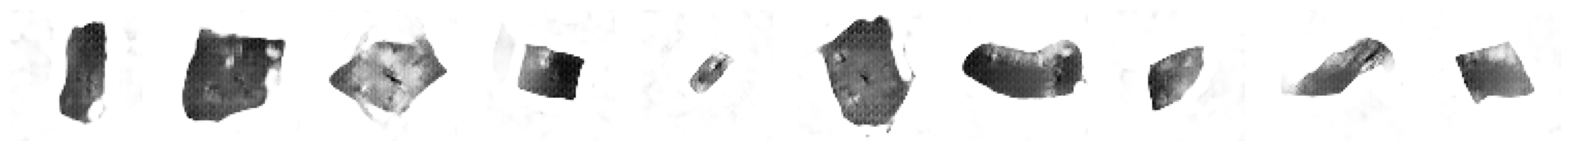

313/313 ━━━━━━━━━━━━━━━━━━━━ 91s 290ms/step - d_acc: 0.9696 - d_fake_acc: 0.9756 - d_loss: -0.4068 - d_real_acc: 0.9636 - g_acc: 0.0244 - g_loss: 12.4106
Epoch 75/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - d_acc: 0.9335 - d_fake_acc: 0.9374 - d_loss: -0.1526 - d_real_acc: 0.9296 - g_acc: 0.0626 - g_loss: 11.0196
Saved to ./output/generated_img_074.png


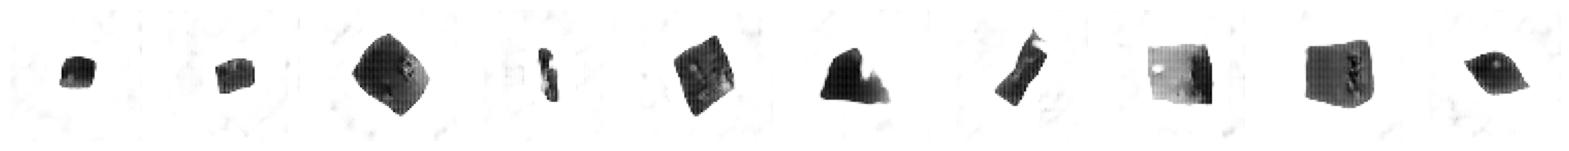

313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 287ms/step - d_acc: 0.9335 - d_fake_acc: 0.9374 - d_loss: -0.1529 - d_real_acc: 0.9296 - g_acc: 0.0626 - g_loss: 11.0198
Epoch 76/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8002 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1172
Saved to ./output/generated_img_075.png


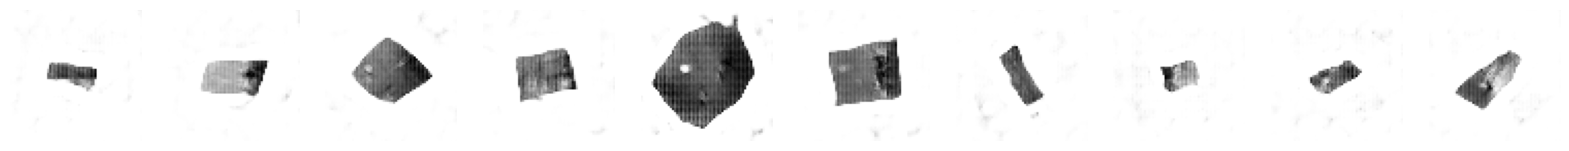

313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 285ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8002 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1172
Epoch 77/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - d_acc: 0.9997 - d_fake_acc: 0.9997 - d_loss: -0.7956 - d_real_acc: 0.9998 - g_acc: 3.0515e-04 - g_loss: 16.0101
Saved to ./output/generated_img_076.png


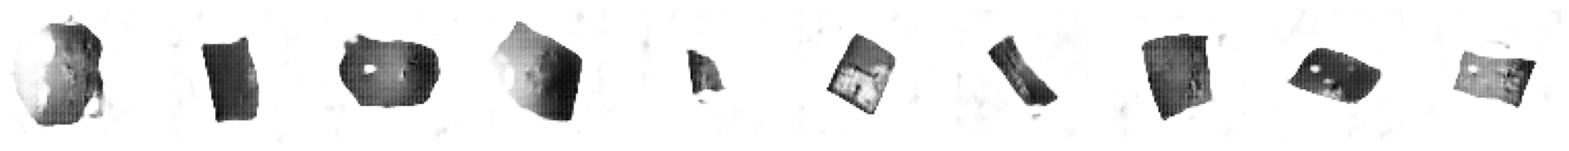

313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 287ms/step - d_acc: 0.9997 - d_fake_acc: 0.9997 - d_loss: -0.7956 - d_real_acc: 0.9998 - g_acc: 3.0530e-04 - g_loss: 16.0100
Epoch 78/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8023 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1179
Saved to ./output/generated_img_077.png


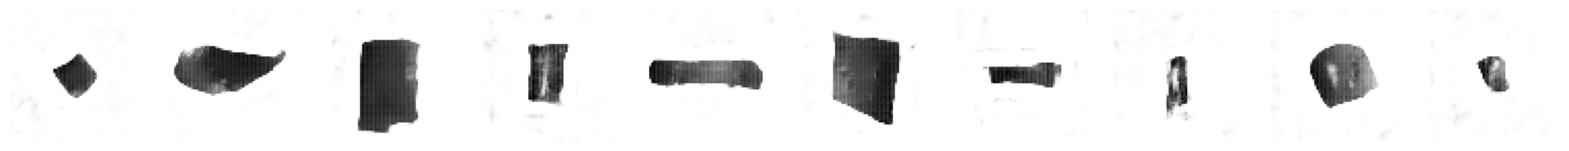

313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 286ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8023 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1179
Epoch 79/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - d_acc: 0.9999 - d_fake_acc: 0.9999 - d_loss: -0.7993 - d_real_acc: 0.9998 - g_acc: 6.7868e-05 - g_loss: 16.0790
Saved to ./output/generated_img_078.png


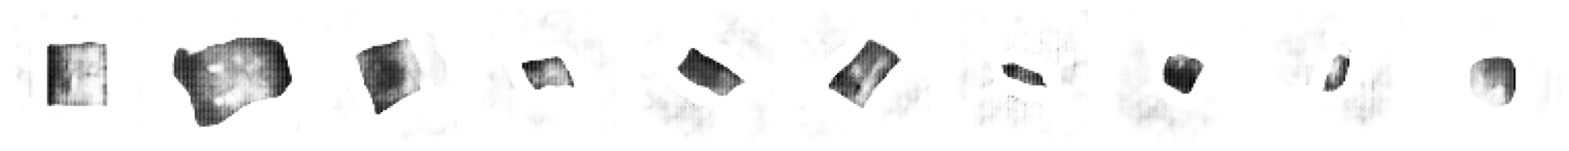

313/313 ━━━━━━━━━━━━━━━━━━━━ 92s 293ms/step - d_acc: 0.9999 - d_fake_acc: 0.9999 - d_loss: -0.7993 - d_real_acc: 0.9998 - g_acc: 6.7812e-05 - g_loss: 16.0790
Epoch 80/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8048 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1180
Saved to ./output/generated_img_079.png


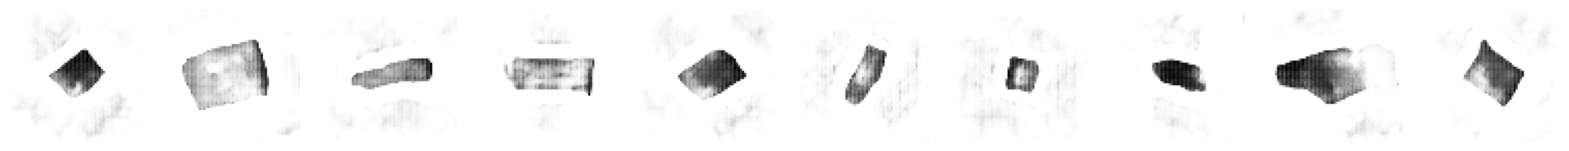

313/313 ━━━━━━━━━━━━━━━━━━━━ 140s 288ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8048 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1180
Epoch 81/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8007 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1177
Saved to ./output/generated_img_080.png


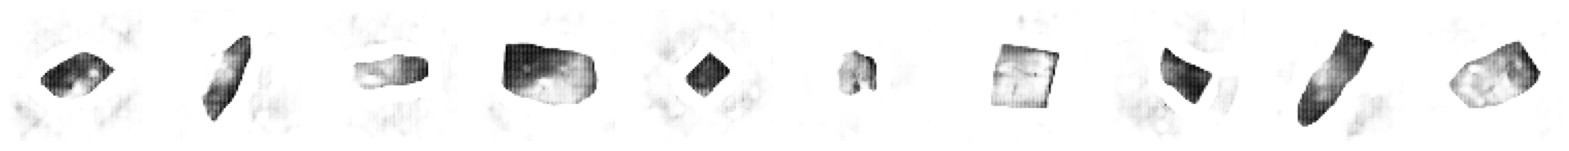

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 289ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8007 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1177
Epoch 82/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8046 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1179
Saved to ./output/generated_img_081.png


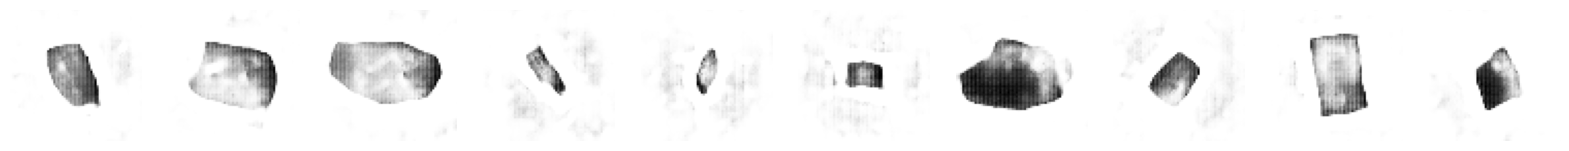

313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 291ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8046 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1179
Epoch 83/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.7986 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1174
Saved to ./output/generated_img_082.png


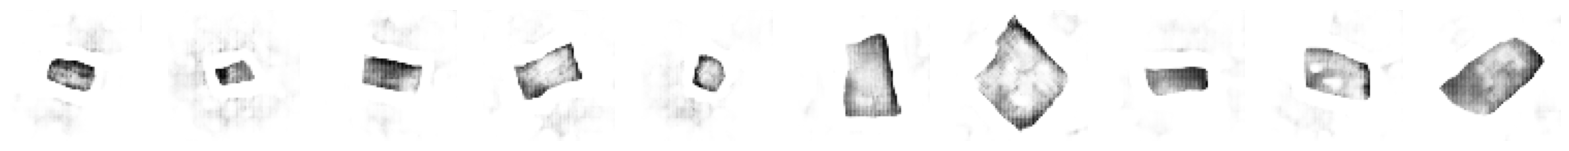

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 293ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.7986 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1174
Epoch 84/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.7977 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1176
Saved to ./output/generated_img_083.png


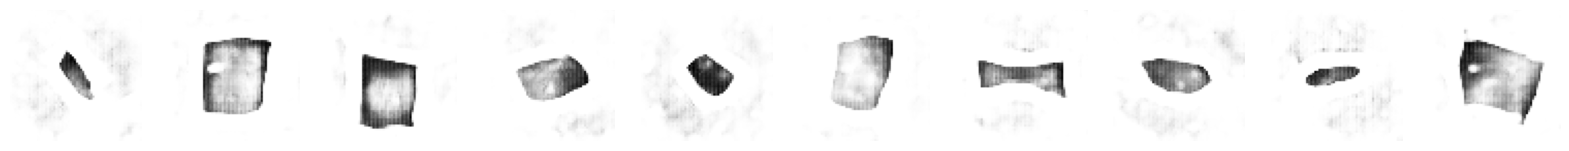

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 294ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.7977 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1176
Epoch 85/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - d_acc: 0.9999 - d_fake_acc: 1.0000 - d_loss: -0.8007 - d_real_acc: 0.9999 - g_acc: 3.6633e-05 - g_loss: 16.0963
Saved to ./output/generated_img_084.png


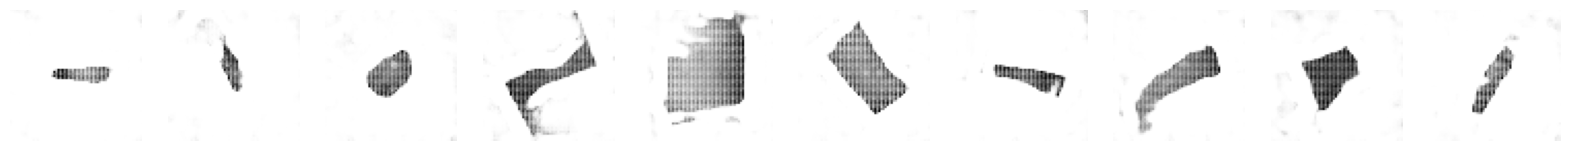

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 292ms/step - d_acc: 0.9999 - d_fake_acc: 1.0000 - d_loss: -0.8007 - d_real_acc: 0.9999 - g_acc: 3.6676e-05 - g_loss: 16.0963
Epoch 86/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8000 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1181
Saved to ./output/generated_img_085.png


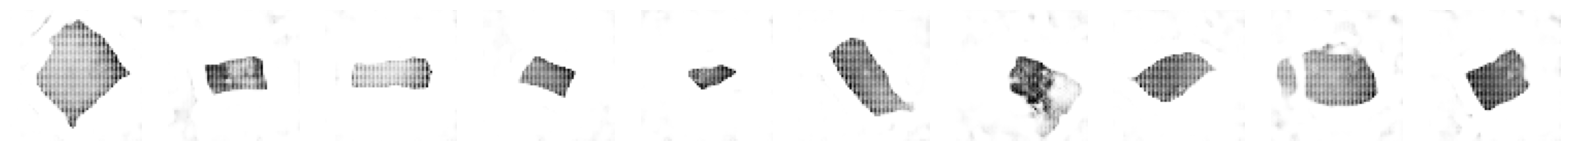

313/313 ━━━━━━━━━━━━━━━━━━━━ 93s 296ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8000 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1181
Epoch 87/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8016 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1181
Saved to ./output/generated_img_086.png


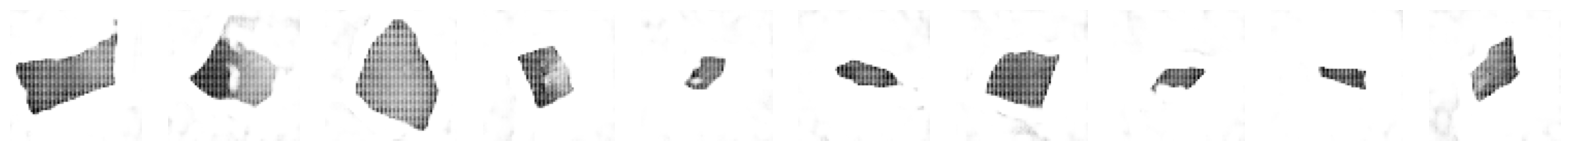

313/313 ━━━━━━━━━━━━━━━━━━━━ 92s 294ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8016 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1181
Epoch 88/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8043 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1181
Saved to ./output/generated_img_087.png


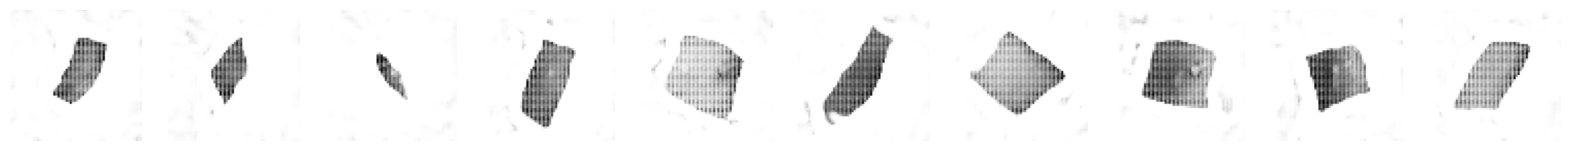

313/313 ━━━━━━━━━━━━━━━━━━━━ 92s 295ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8043 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1181
Epoch 89/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.7999 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1181
Saved to ./output/generated_img_088.png


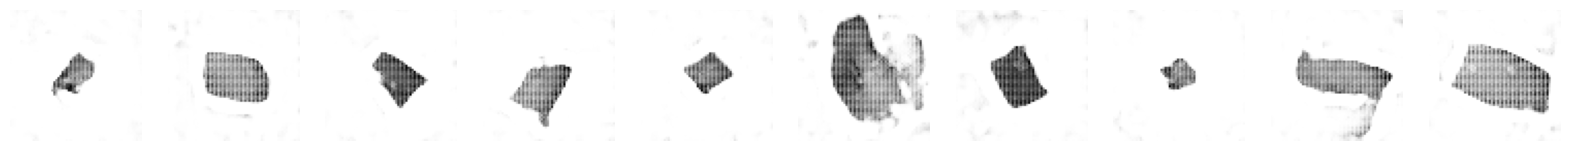

313/313 ━━━━━━━━━━━━━━━━━━━━ 93s 295ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.7999 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1181
Epoch 90/300
  2/313 ━━━━━━━━━━━━━━━━━━━━ 1:04 206ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.7734 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1181 

In [ ]:
dcgan.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

In [ ]:
# Save the final models
generator.save("./models/generator.keras")
discriminator.save("./models/discriminator.keras")

## 3. Generate new images <a name="decode"></a>

In [ ]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [ ]:
# Decode the sampled points
reconstructions = generator.predict(z_sample)

In [ ]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

In [ ]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [ ]:
all_data = []
for i in train.as_numpy_iterator():
    all_data.extend(i)
all_data = np.array(all_data)

In [ ]:
r, c = 3, 5
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Generated images", fontsize=20)

noise = np.random.normal(size=(r * c, Z_DIM))
gen_imgs = generator.predict(noise)

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(gen_imgs[cnt], cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

In [ ]:
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Closest images in the training set", fontsize=20)

cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(all_data):
            diff = compare_images(gen_imgs[cnt], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img, cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()